# **Predict change in b-cells in Ritixumab treated samples**
In this notebook I use the models trained in the hyperparameter search in order to XXX



# **Imports**

In [8]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
from scipy.stats import rankdata
from sklearn.metrics import average_precision_score, f1_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [9]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_synovium_data/"
bulk_aug_data_path = f"{os.getcwd()}/../data/bulk_data/synovium/"
reference_data_path = f"{os.getcwd()}/../data/reference_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_synovium/"
clinical_file = f"{os.getcwd()}/../data/single_cell_data/synovium/metadata_clin_donor_singlecell.csv"


cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_synovium/"


cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_synovium/" +
                        "CIBERSORTx_Job31_test_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job31_test_cybersort_sig_inferred_refsample.bm.K999.txt")


num_genes = 7000

exp_id = "all-synovium"
res_id = "rit-synovium"

# Set-up experimental variables

In [10]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 6

# number of patients/domains/samples expected
n_tot_samples = 83 # 12 bulk and 11 single cell samples
n_tot_samples = 76 # 72 bulk and 4 single cell samples
n_tot_samples = 108 # 101 bulk and 7 single cell samples
n_tot_samples = 79 # 72 bulk and 7 single cell samples
n_tot_samples = 19 # 12 bulk and 7 single cell samples -- CITESEQ, Ankle

# number of drugs (in this case sexes used for prediction)
# one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [11]:
in_name = "synovium_bulk_processed_Rituximab"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)


# now get the sc ref training data

# read in order
sample_order = ['BRI-462', 'BRI-566', 'BRI-458', 'BRI-460', 'BRI-421', 'BRI-601',
                'BRI-605', 'BRI-515', 'BRI-415', 'BRI-623', 'BRI-436']
sample_order = ['BRI-601', 'BRI-623', 'BRI-605', 'BRI-566']
sample_order = ['BRI-462', 'BRI-458', 'BRI-460', 'BRI-421',
                'BRI-515', 'BRI-415', 'BRI-436']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", res_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
real_bulk_meta_df['response'] = real_bulk_meta_df['sampling_time_point'].astype(str)
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim", "response"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

meta_concat['response'] = '0'


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])

# add clinical info
clinical_df = pd.read_csv(clinical_file)
clinical_df = meta_df.merge(clinical_df, left_on="sample_id", right_on="mRNA_run", how='left')
meta_df = clinical_df

# update technologies
sc_tech_idx = np.where(meta_df.samp_type == "sc_ref")[0]
meta_df.samp_type.iloc[sc_tech_idx] = meta_df.single_cell_tech.iloc[sc_tech_idx]


BRI-462
BRI-458
BRI-460
BRI-421
BRI-515
BRI-415
BRI-436


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/2433036500.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/2433036500.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/2433036500.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [12]:
tab = meta_df.groupby(['samp_type', 'response']).size()
tab.unstack()

response                              0    16
samp_type                                    
CITEseq                          6800.0   NaN
CITEseq + flow/bulk              1700.0   NaN
CITEseq + flow/bulk + re-freeze  3400.0   NaN
bulk                               12.0  12.0

### format sample indicies and get variable genes

In [13]:
meta_df.isTraining.unique()

array(['Train'], dtype=object)

In [14]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]
idx_random = np.where(meta_df.cell_prop_type == "random")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)



# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, cibersort_genes)
    #CoV_only = top_gene_df
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]


In [15]:
X_orig

array([[8.8400e+02, 9.0000e+01, 2.4710e+03, ..., 2.0770e+03, 3.4680e+03,
        1.0860e+03],
       [4.0000e+02, 5.6000e+01, 1.8310e+03, ..., 2.1850e+03, 2.3700e+03,
        1.0610e+03],
       [4.8900e+02, 8.4000e+01, 2.3760e+03, ..., 2.1830e+03, 3.2180e+03,
        1.1140e+03],
       ...,
       [3.1300e+02, 4.5000e+01, 2.9257e+04, ..., 9.0400e+02, 1.1214e+04,
        2.7720e+03],
       [3.7600e+02, 5.0000e+01, 5.9200e+03, ..., 7.0500e+02, 4.7120e+03,
        1.9540e+03],
       [3.6000e+02, 2.9000e+01, 3.6597e+04, ..., 1.5550e+03, 6.8600e+03,
        4.4080e+03]])

In [16]:
X_CoV.shape

(16151,)

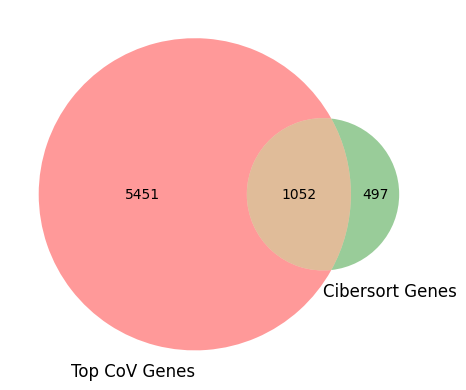

In [17]:
venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [18]:
union_genes = np.union1d(gene_df, cibersort_genes)
#union_genes = gene_df
len(union_genes)

7000

### normalize

In [19]:
X_full = X_full.loc[:,union_genes]

# rescale sc_ref and bulks
median_sc_ref = np.median(np.median(X_full.iloc[0:11200], axis=1))
median_bulk = np.median(np.median(X_full.iloc[11200:], axis=1))

ratio_medians = median_bulk/median_sc_ref

X_full.iloc[0:11200] = X_full.iloc[0:11200]*ratio_medians

In [20]:

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


### plot data

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 11924 samples in 0.331s...
[t-SNE] Computed neighbors for 11924 samples in 10.763s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11924
[t-SNE] Computed conditional probabilities for sample 2000 / 11924
[t-SNE] Computed conditional probabilities for sample 3000 / 11924
[t-SNE] Computed conditional probabilities for sample 4000 / 11924
[t-SNE] Computed conditional probabilities for sample 5000 / 11924
[t-SNE] Computed conditional probabilities for sample 6000 / 11924
[t-SNE] Computed conditional probabilities for sample 7000 / 11924
[t-SNE] Computed conditional probabilities for sample 8000 / 11924
[t-SNE] Computed conditional probabilities for sample 9000 / 11924
[t-SNE] Computed conditional probabilities for sample 10000 / 11924
[t-SNE] Computed conditional probabilities for sample 11000 / 11924
[t-SNE] Computed conditional probabilities for sample 11924 / 11924
[t-SNE] Mean sigma: 0.444458
[t-SNE] KL divergenc

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/2884562472.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


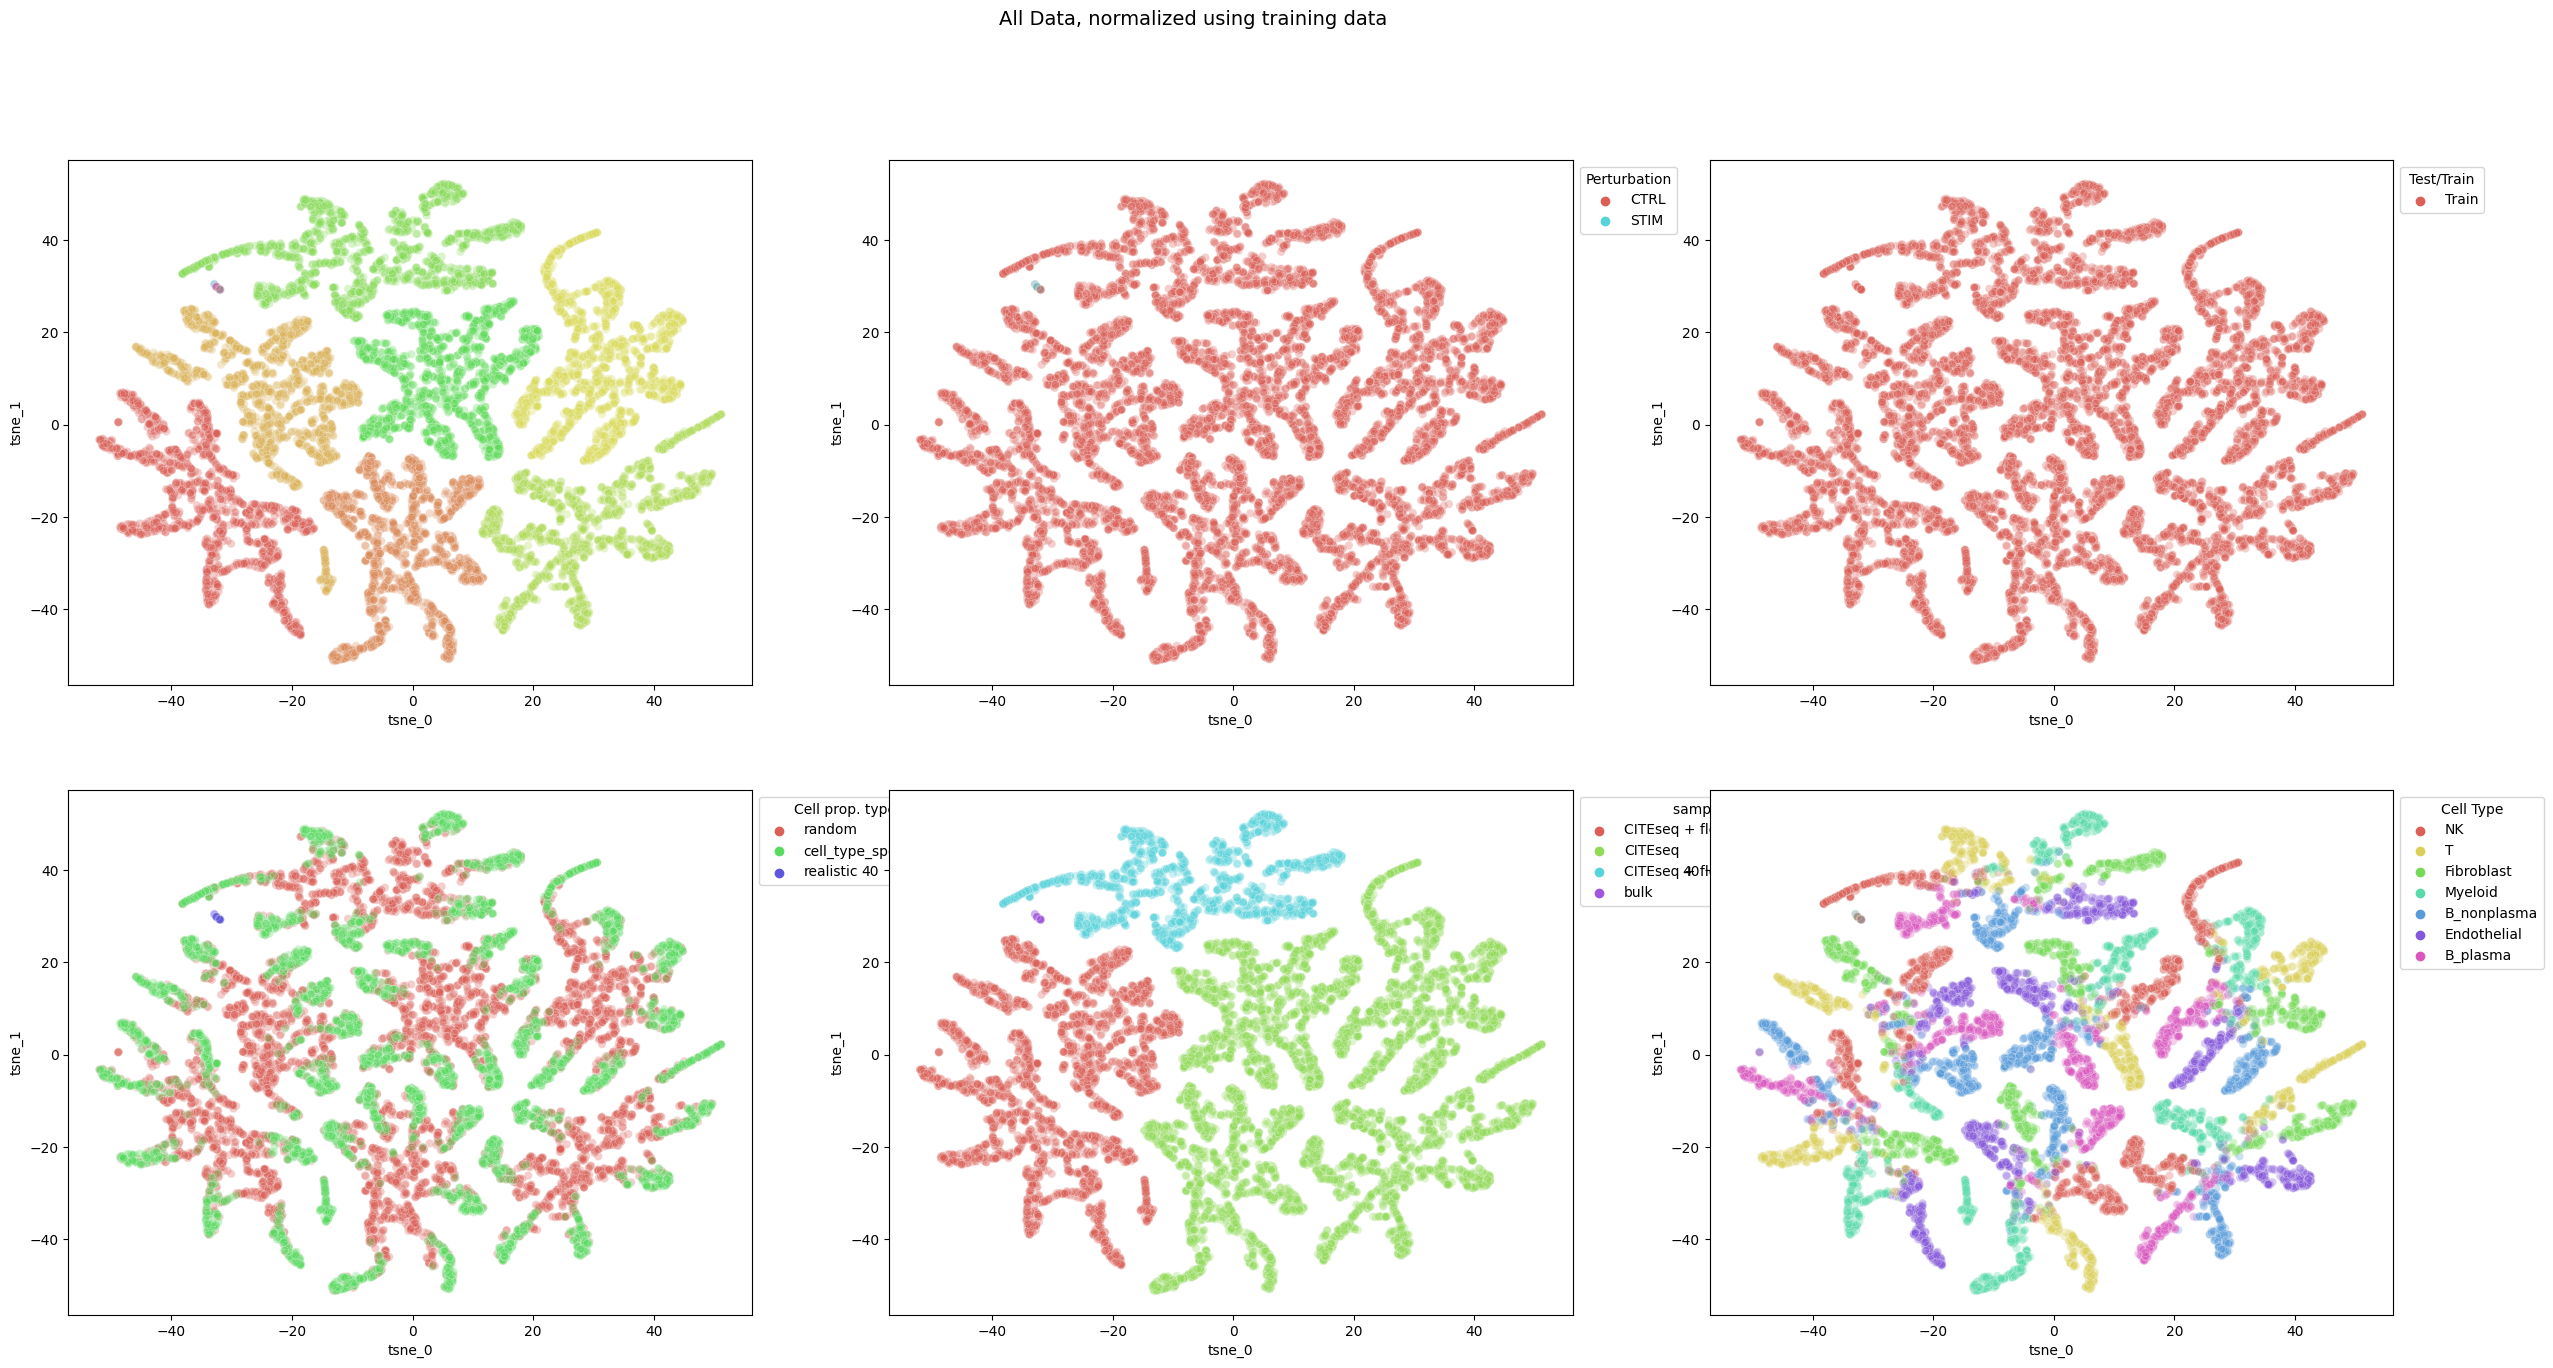

In [21]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

# this is a vector that represents the cell-type with 
# the highest proportion 
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]


vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(24, 2)
(24, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/2821073111.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


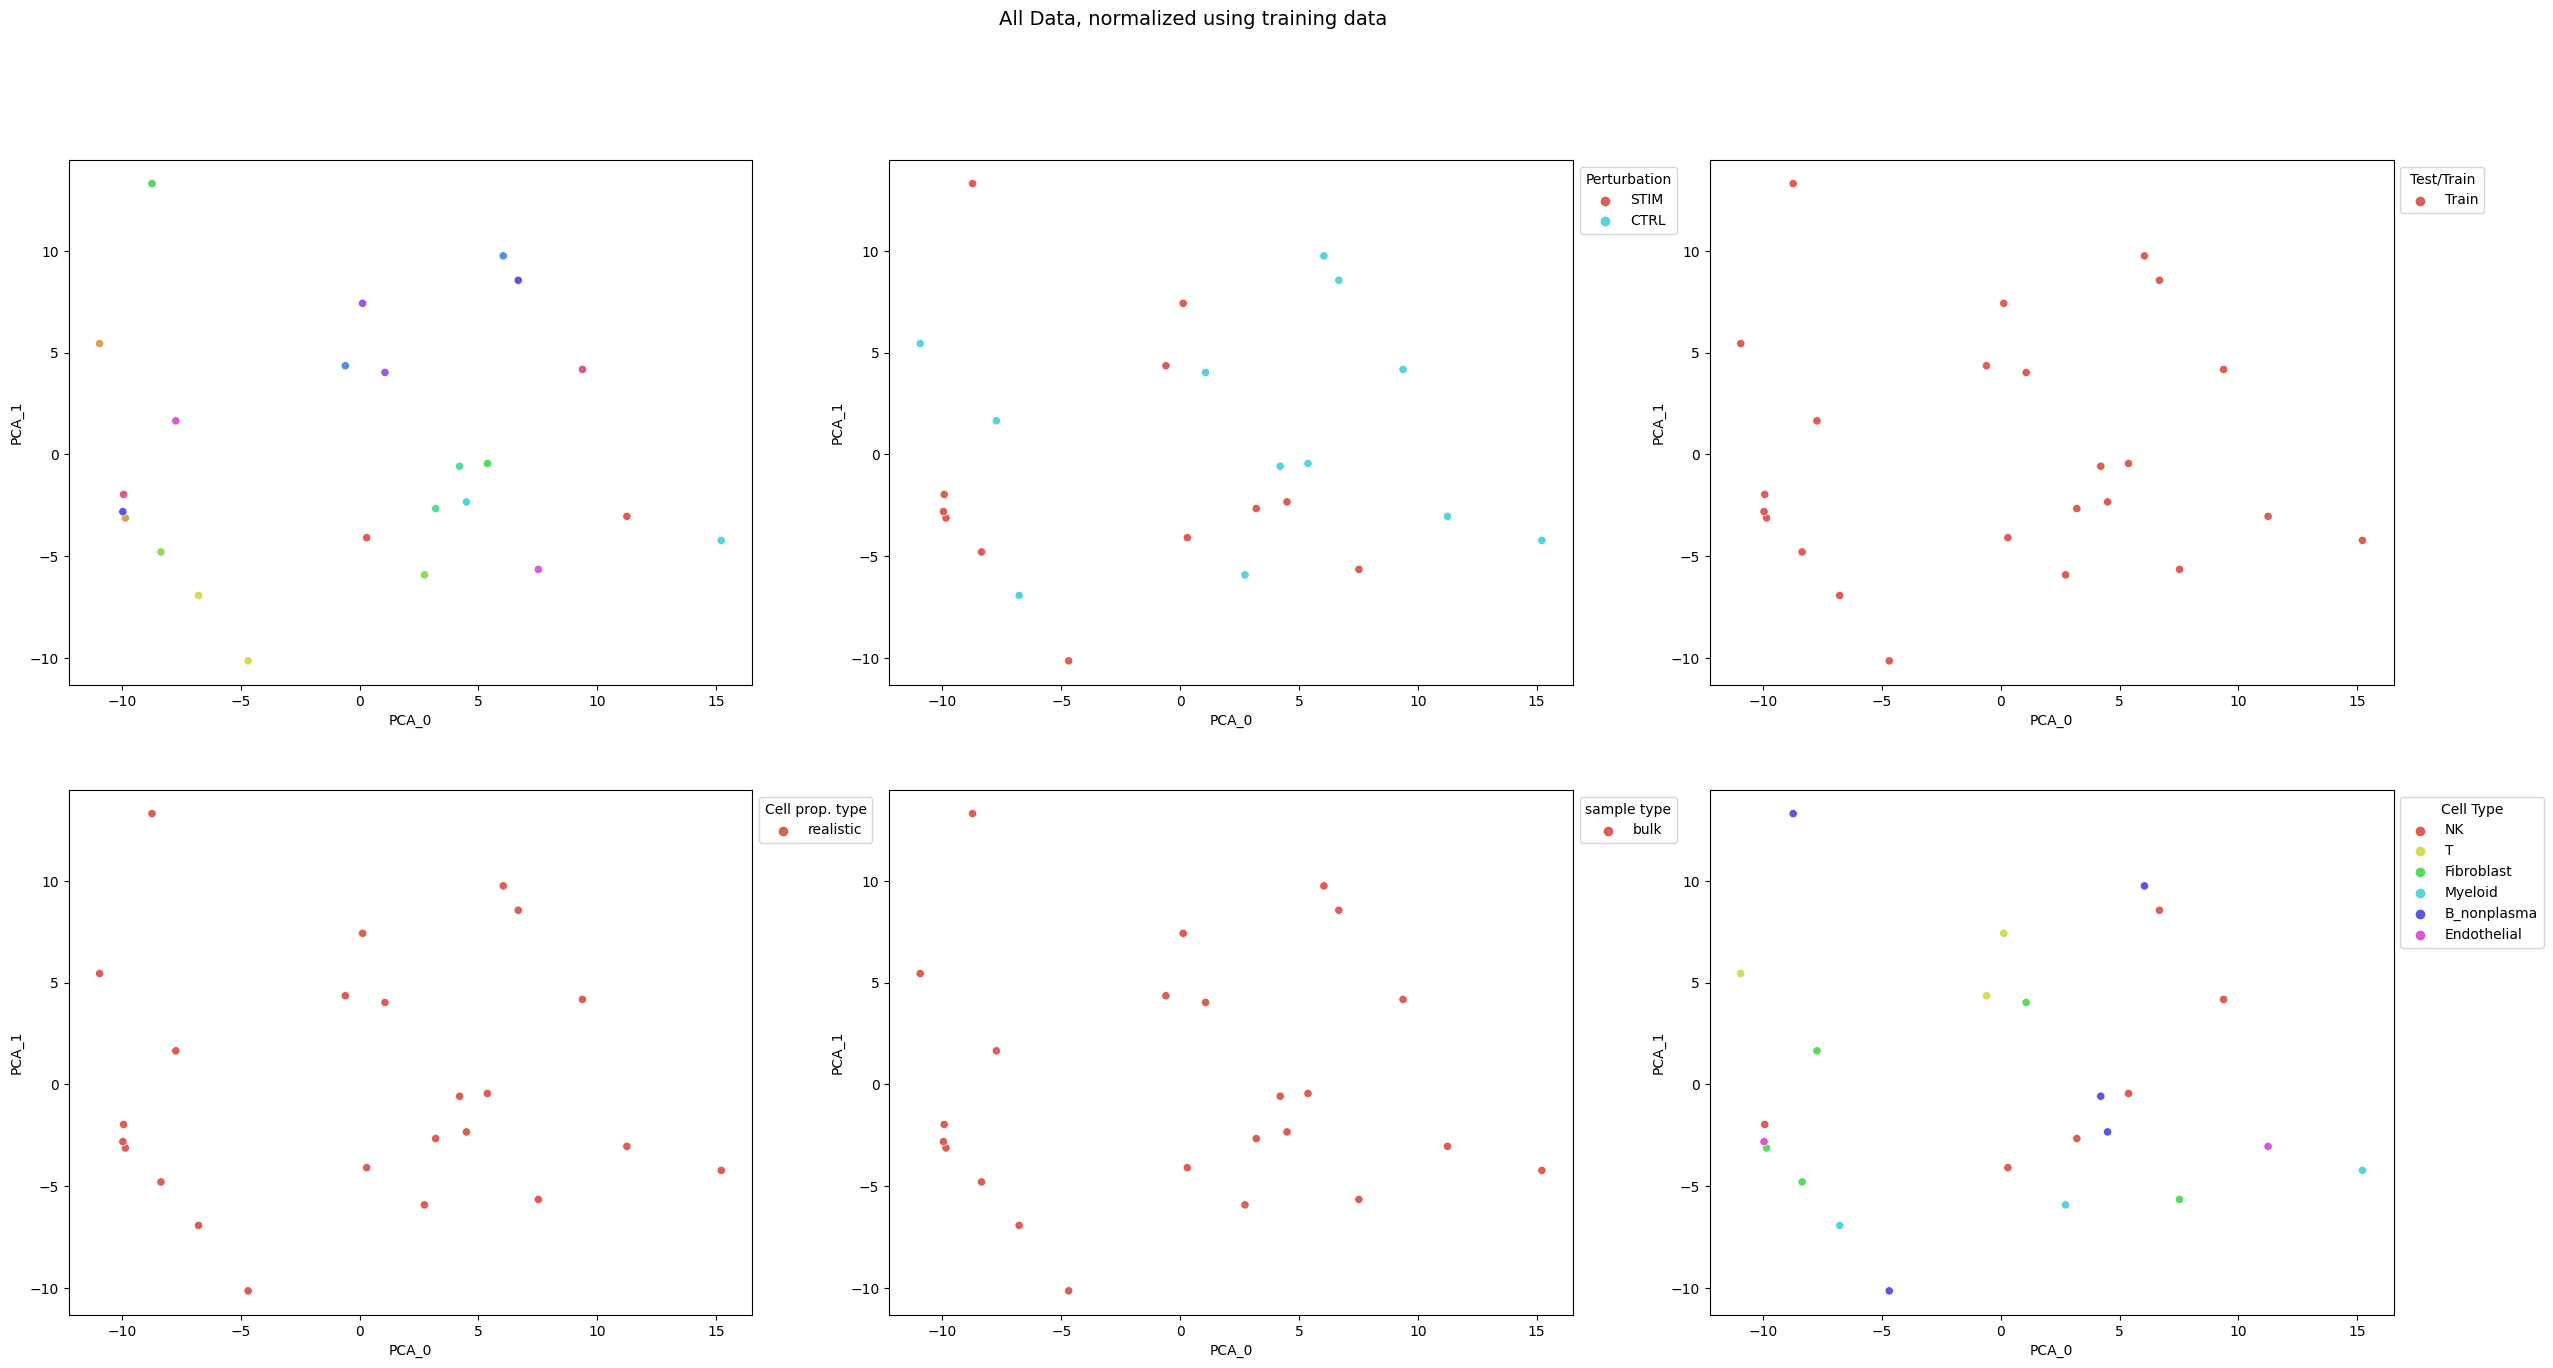

In [22]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1, legend_title="Sample ID")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1, legend_title="Perturbation")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1, legend_title="Test/Train")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1, legend_title="Cell prop. type")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1, legend_title="sample type")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


[t-SNE] Computing 23 nearest neighbors...
[t-SNE] Indexed 24 samples in 0.000s...
[t-SNE] Computed neighbors for 24 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 14.576820
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.362381
[t-SNE] KL divergence after 500 iterations: 0.249759
(24, 2)
(24, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/2955274557.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


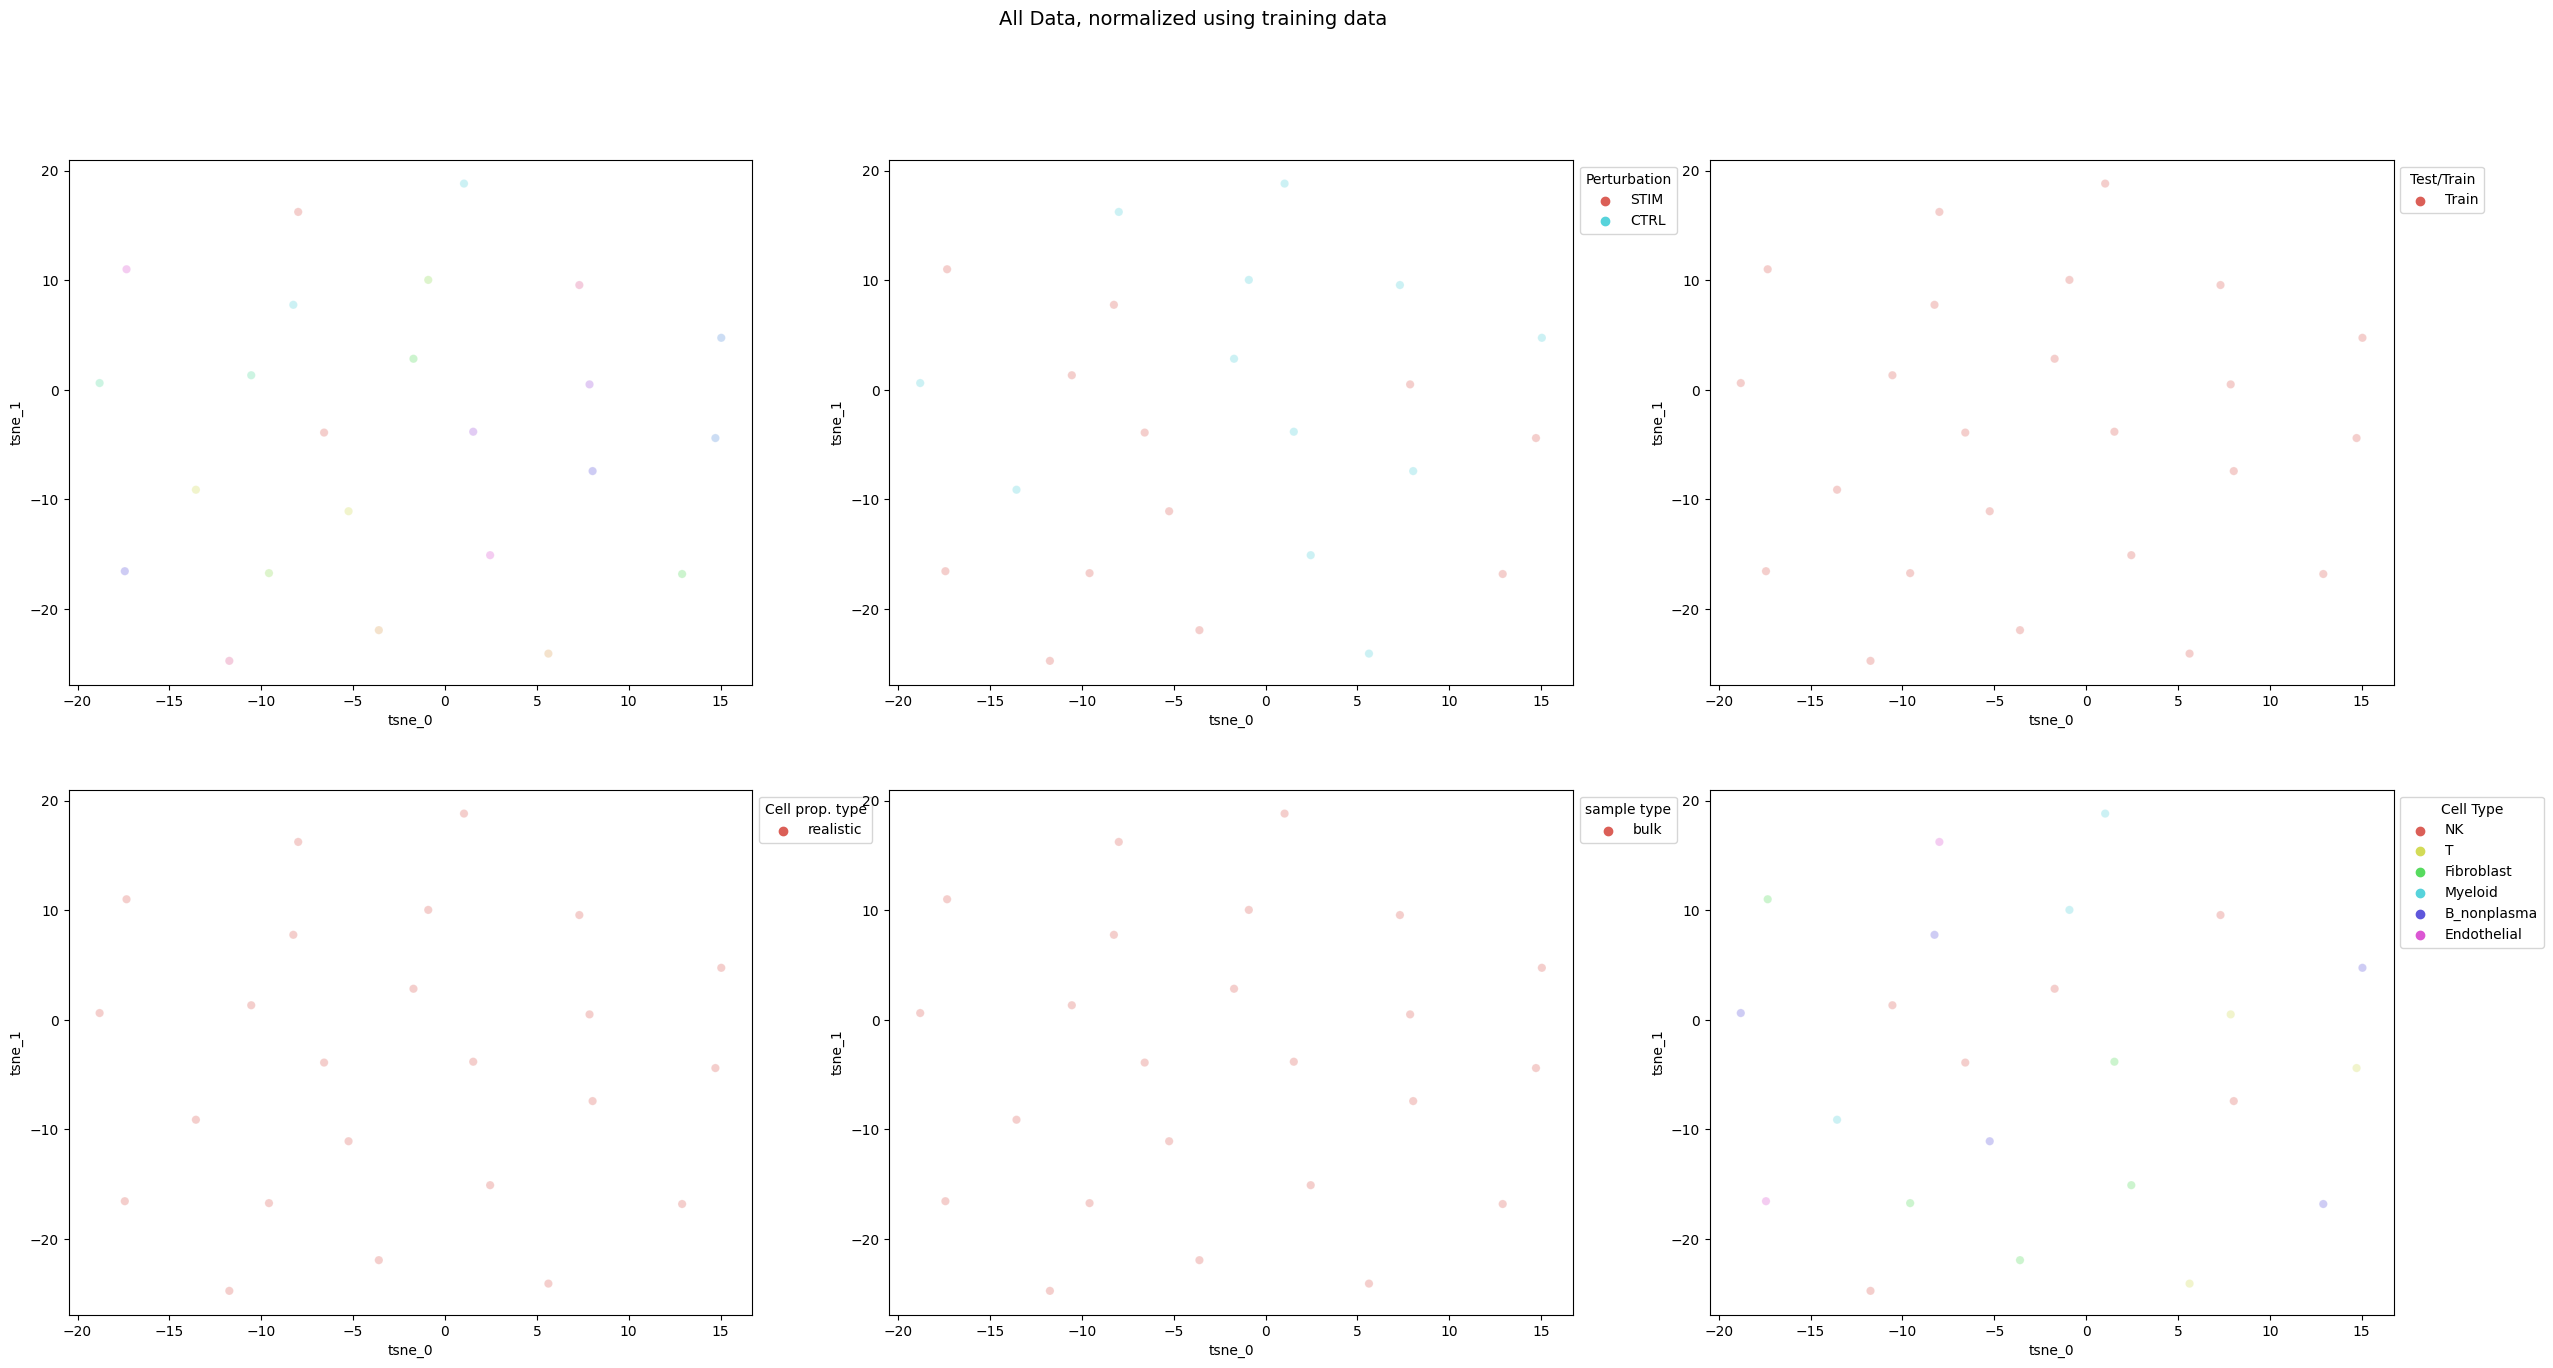

In [23]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], alpha=1, title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], alpha=1, title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], alpha=1, title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], alpha=1, title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], alpha=1, title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Read in Trained Models**

In [24]:

res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model1_{res_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model1_{res_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/model1_{res_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/model1_{res_id}_classifier")

"""
res2_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_encoder_unlab")
res2_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_encoder_lab")
res2_dec = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_decoder")
res2_classifier = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_classifier")


res3_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_encoder_unlab")
res3_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_encoder_lab")
res3_dec = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_decoder")
res3_classifier = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_classifier")

"""


2024-01-19 23:54:08.731651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-01-19 23:54:08.753146: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_6' id:268 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_6}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_11, Identity_6)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-01-19 23:54:09.343163: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_28' id:647 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_28}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_22, Identity_28)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-01-19 23:54:09.573672: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_51' id:839 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_51}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_25, Identity_51)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-19 23:54:09.774801: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_57' id:928 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_57}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_28, Identity_57)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigge

'\nres2_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_encoder_unlab")\nres2_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_encoder_lab")\nres2_dec = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_decoder")\nres2_classifier = tf.keras.models.load_model(f"{res_data_path}/model2_{exp_id}_classifier")\n\n\nres3_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_encoder_unlab")\nres3_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_encoder_lab")\nres3_dec = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_decoder")\nres3_classifier = tf.keras.models.load_model(f"{res_data_path}/model3_{exp_id}_classifier")\n\n'

## Do latent space projectsions

### drug perturbation

In [25]:

res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, res1_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res1_enc_unlab, res1_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)

"""

res2_meta_df, res2_decoded_0_0, res2_decoded_0_1, res2_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res2_enc_unlab, res2_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)


res3_meta_df, res3_decoded_0_0, res3_decoded_0_1, res3_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res3_enc_unlab, res3_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)
"""


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-19 23:54:10.427456: W tensorflow/c/c_api.cc:304] Operation '{name:'tf_op_layer_z_samp_slack_5/add/z_samp_slack_5/add' id:375 op device:{requested: '', assigned: ''} def:{{{node tf_op_layer_z_samp_slack_5/add/z_samp_slack_5/add}} = AddV2[T=DT_FLOAT, _cloned=true, _has_manual_control_dependencies=true](mu_slack/BiasAdd, tf_op_layer_z_samp_slack_5/mul/z_samp_slack_5/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/davidnat/Documents/projects/greenelab/buddi/buddi/buddi.py:893: SettingWithCop

'\n\nres2_meta_df, res2_decoded_0_0, res2_decoded_0_1, res2_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, \n                                                                            res2_enc_unlab, res2_dec, batch_size=500, \n                                                                            genes_ordered=union_genes, \n                                                                            top_lim=100, use_buddi4=True)\n\n\nres3_meta_df, res3_decoded_0_0, res3_decoded_0_1, res3_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, \n                                                                            res3_enc_unlab, res3_dec, batch_size=500, \n                                                                            genes_ordered=union_genes, \n                                                                            top_lim=100, use_buddi4=True)\n'

"\ncell_diff = from_contents(res2_top_genes)\nax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()\n\ncell_diff = from_contents(res3_top_genes)\nax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()\n"

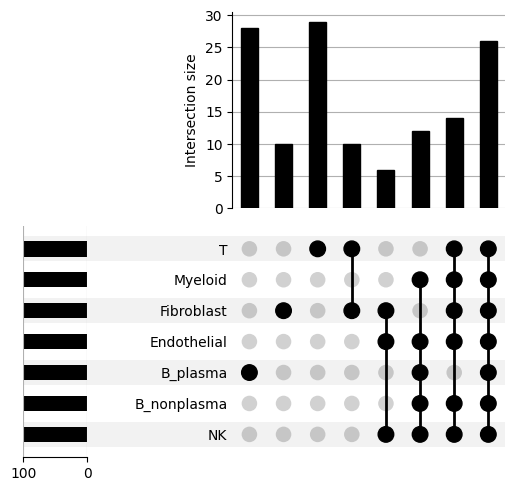

In [26]:
# identify how cell-type specific the DE genes are
cell_diff = from_contents(res1_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()
"""
cell_diff = from_contents(res2_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

cell_diff = from_contents(res3_top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()
"""



In [27]:
res1_top_genes

{'NK': ['PLIN4',
  'ADH1B',
  'APOD',
  'IGHV3-15',
  'IGHV1-3',
  'PLIN1',
  'IGHV3-21',
  'IGHV3-11',
  'LPL',
  'FABP4',
  'TGM2',
  'IL1RN',
  'G0S2',
  'SPP1',
  'IGHV4-34',
  'IGHV1-24',
  'IGHV3-48',
  'GPD1',
  'IGHV3-74',
  'IL4I1',
  'SLAMF7',
  'CXCL14',
  'IGLV4-69',
  'OGN',
  'GBP5',
  'MMP9',
  'RGS1',
  'TPSB2',
  'HK2',
  'SMOC1',
  'IGKV1-9',
  'IGHV4-59',
  'IGLV6-57',
  'FCGR1A',
  'IGHV6-1',
  'IGKV1-27',
  'AQP9',
  'FNDC1',
  'IGHV1-46',
  'CCR5',
  'IGLV1-47',
  'CRISPLD1',
  'CD300E',
  'TENT5C',
  'IGHV3-49',
  'IGHV2-5',
  'TFRC',
  'GBP1',
  'ANGPTL1',
  'FCN1',
  'IRF4',
  'C7',
  'HMCN1',
  'EDIL3',
  'IGHV1-2',
  'STARD9',
  'HLA-DQA2',
  'CD79A',
  'EGR2',
  'PTN',
  'PRKAR2B',
  'TLR8',
  'PTPRD',
  'MZB1',
  'PLEKHG5',
  'SEL1L3',
  'IGHV3-23',
  'SLC39A8',
  'IGLV3-25',
  'IGHV5-51',
  'TEDC1',
  'CXCL8',
  'SPEG',
  'PDGFRL',
  'PPP1R1A',
  'MS4A1',
  'JCHAIN',
  'PDK4',
  'ATF5',
  'PER3',
  'TPSAB1',
  'SLC2A3',
  'LILRB1',
  'CD36',
  'TMEM119',
 

In [28]:

# make predictions
prop_outputs_00 = res1_classifier.predict(res1_decoded_0_0, batch_size=500)
prop_outputs_01 = res1_classifier.predict(res1_decoded_0_1, batch_size=500)

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-19 23:54:22.719810: W tensorflow/c/c_api.cc:304] Operation '{name:'cls_out/Softmax' id:943 op device:{requested: '', assigned: ''} def:{{{node cls_out/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](cls_out/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [29]:
prop_outputs_01

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [30]:
res1_meta_df

sample_id  stim isTraining      cell_prop_type  \
4585    BRI-460  CTRL       Test  cell_type_specific   
11310   BRI-436  CTRL       Test  cell_type_specific   
6633    BRI-421  CTRL       Test  cell_type_specific   
6410    BRI-421  CTRL       Test  cell_type_specific   
3185    BRI-458  CTRL       Test  cell_type_specific   
...         ...   ...        ...                 ...   
11803   BRI-436  CTRL       Test  cell_type_specific   
9991    BRI-415  CTRL       Test  cell_type_specific   
8287    BRI-515  CTRL       Test  cell_type_specific   
9641    BRI-415  CTRL       Test  cell_type_specific   
8352    BRI-515  CTRL       Test  cell_type_specific   

                             samp_type response subject_id pipeline_date  \
4585   CITEseq + flow/bulk + re-freeze        0   300-0173       8/22/19   
11310                          CITEseq        0   300-0223       8/15/19   
6633                           CITEseq        0   300-0501       8/12/19   
6410                           CITEseq        0   300-0501       8/12/19   
3185                           CITEseq        0   300-2666       8/22/19   
...                                ...      ...        ...           ...   
11803                          CITEseq        0   300-0223       8/15/19   
9991               CITEseq + flow/bulk        0   300-1933       8/12/19   
8287                           CITEseq        0   300-0504       9/17/19   
9641               CITEseq + flow/bulk        0   300-1933       8/12/19   
8352                           CITEseq        0   300-0504       9/17/19   

                               site treatment  ...  tissue_type krenn_lining  \
4585   Hospital for Special Surgery         1  ...  Synovectomy         0.33   
11310        University of Colorado         1  ...       Biopsy         1.33   
6633                  UK Birmingham         1  ...       Biopsy         1.33   
6410                  UK Birmingham         1  ...       Biopsy         1.33   
3185            Columbia University         1  ...       Biopsy         1.33   
...                             ...       ...  ...          ...          ...   
11803        University of Colorado         1  ...       Biopsy         1.33   
9991                      UK London         1  ...       Biopsy         1.33   
8287                  UK Birmingham         1  ...       Biopsy         0.67   
9641                      UK London         1  ...       Biopsy         1.33   
8352                  UK Birmingham         1  ...       Biopsy         0.67   

       krenn_inflammation                 single_cell_tech  cell_count_to_10x  \
4585                 2.33  CITEseq + flow/bulk + re-freeze             12,100   
11310                3.00                          CITEseq             12,000   
6633                 2.33                          CITEseq             12,400   
6410                 2.33                          CITEseq             12,400   
3185                 3.00                          CITEseq              8,500   
...                   ...                              ...                ...   
11803                3.00                          CITEseq             12,000   
9991                 2.67              CITEseq + flow/bulk             15,000   
8287                 1.67                          CITEseq              11500   
9641                 2.67              CITEseq + flow/bulk             15,000   
8352                 1.67                          CITEseq              11500   

      mRNA_run  protein_run  atac_run    qc        Y_max  
4585   BRI-460      BRI-461   BRI-545  Pass  B_nonplasma  
11310  BRI-436      BRI-437       NaN  Pass  B_nonplasma  
6633   BRI-421      BRI-422       NaN  Pass      Myeloid  
6410   BRI-421      BRI-422       NaN  Pass  Endothelial  
3185   BRI-458      BRI-459   BRI-646  Pass   Fibroblast  
...        ...          ...       ...   ...          ...  
11803  BRI-436      BRI-437       NaN  Pass            T  
9991   BRI-415

# **Plot deconvolution estimates**


Here, we will plot the estimates of the bulks we used in training that were either labeled (CTRL samples) or unlabeled (STIM samples).

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/1662931566.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


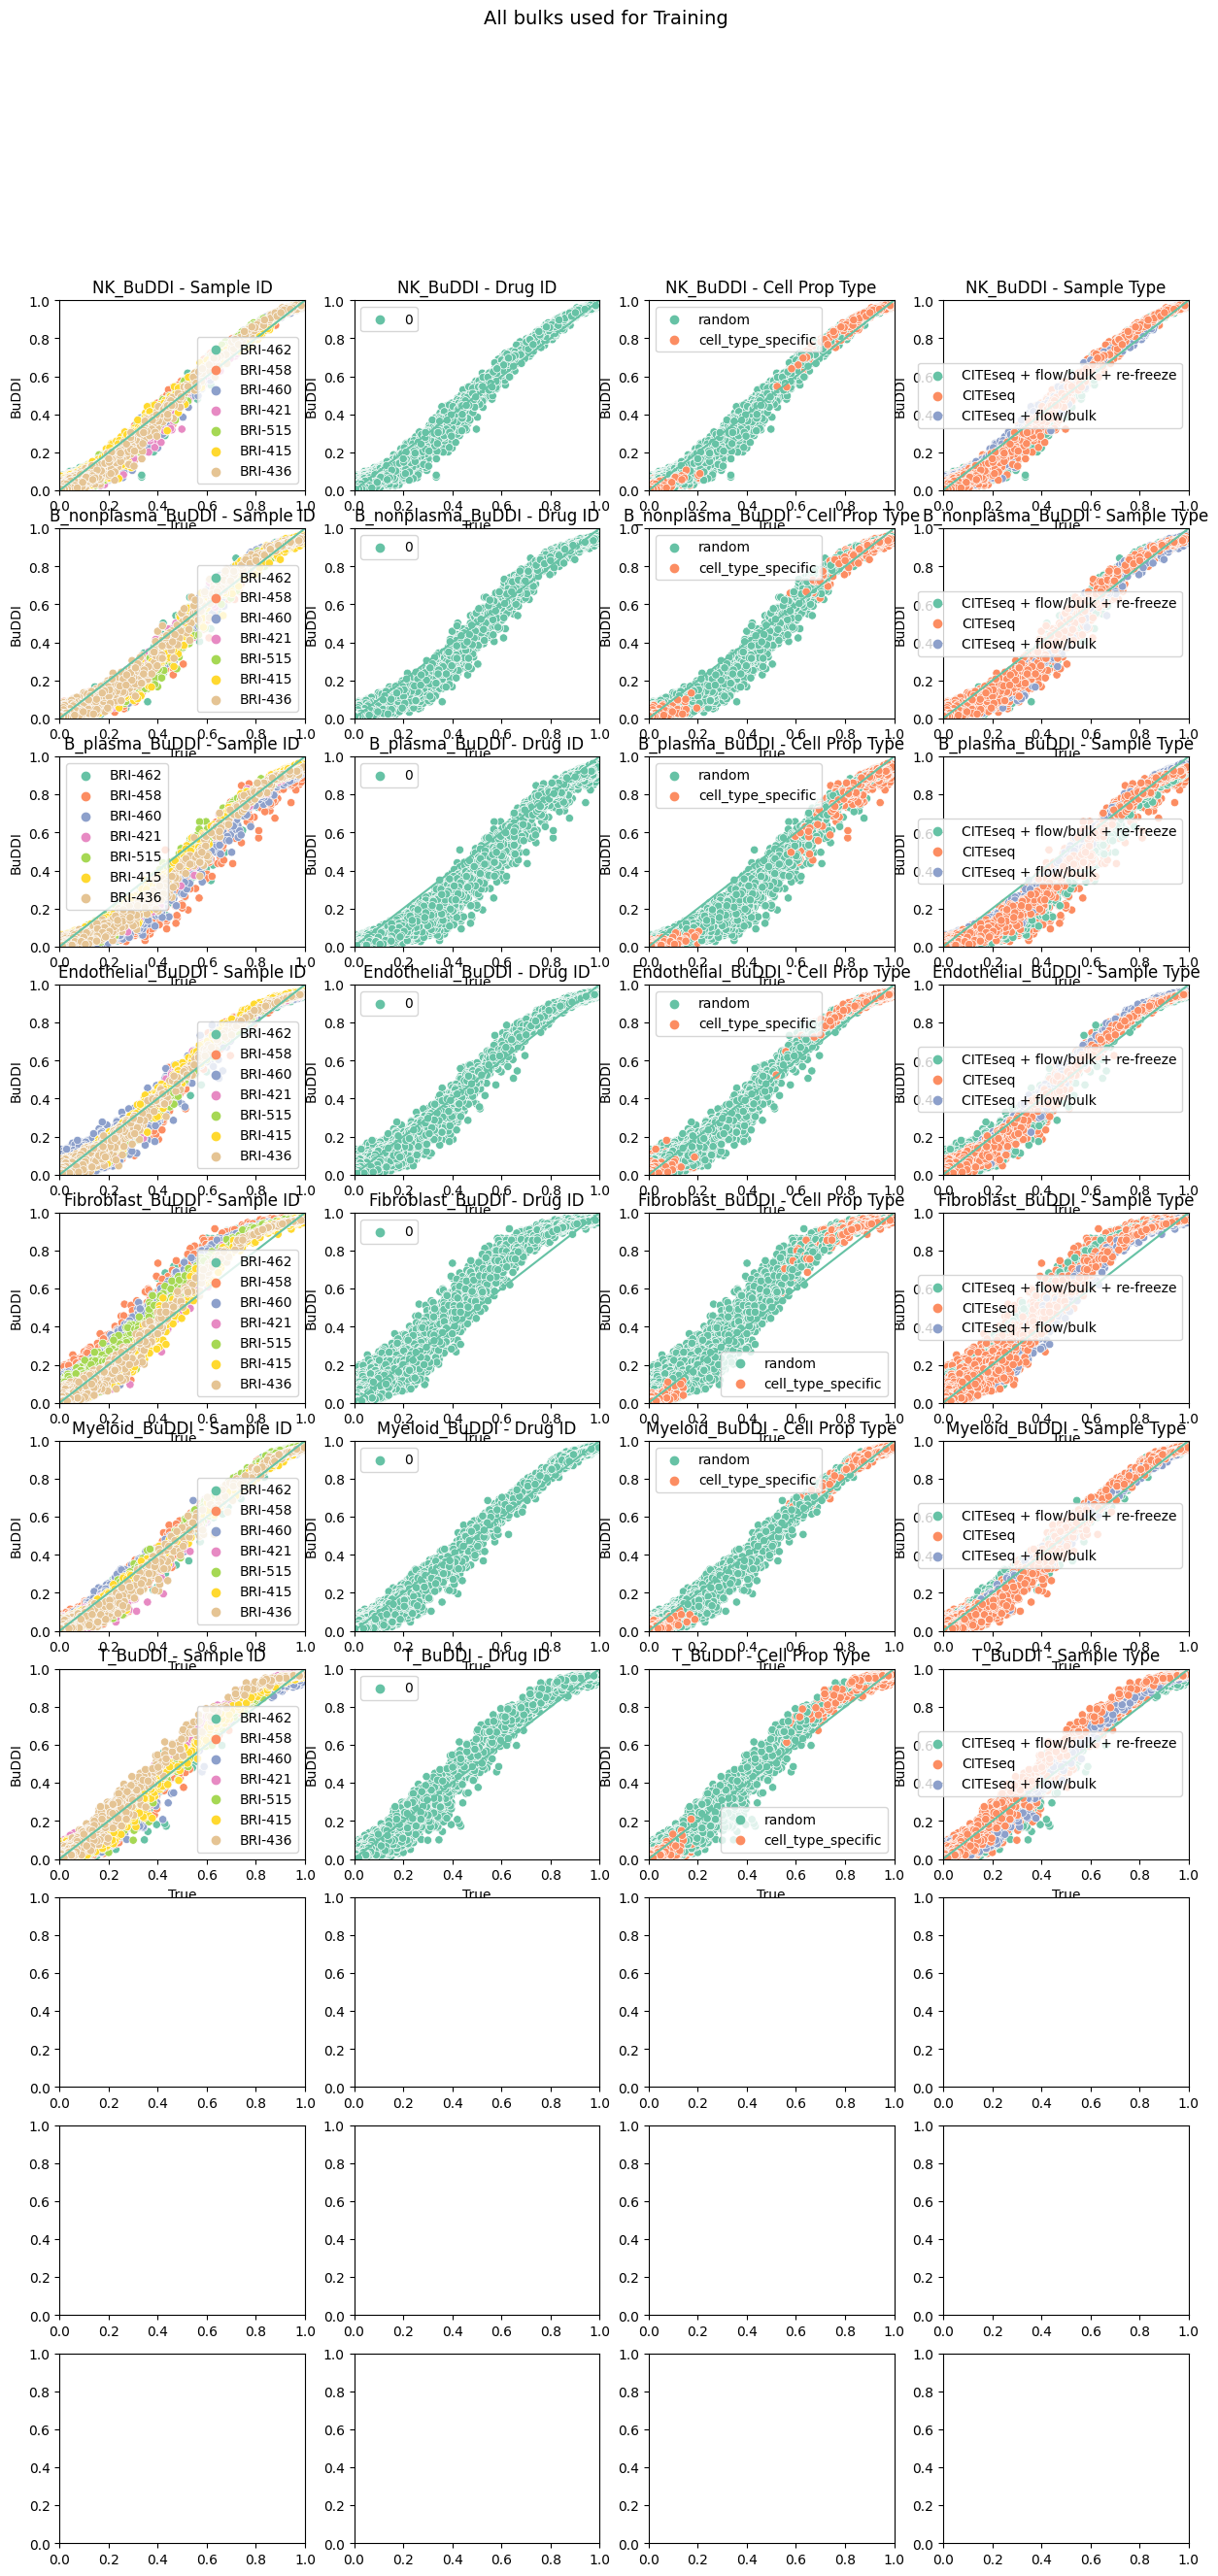

In [31]:
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type != "bulk"))[0]
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = res1_classifier.predict(X_tmp, batch_size=500)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_full.columns)
true_prop_df = Y_full.iloc[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = index_label[label_temp]



fig, axs = plt.subplots(10, 4, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    vp.plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=label_temp[idx_tmp])
    vp.plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    vp.plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,2], title=f"{curr_cell}_BuDDI - Cell Prop Type", xlab="True", ylab="BuDDI", class_id=meta_df.cell_prop_type.to_numpy()[idx_tmp])
    vp.plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,3], title=f"{curr_cell}_BuDDI - Sample Type", xlab="True", ylab="BuDDI", class_id=meta_df.samp_type.to_numpy()[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("All bulks used for Training", fontsize=14)

fig.show()



In [32]:
prop_outputs

array([[0.2795012 , 0.04172568, 0.02867449, ..., 0.27612224, 0.24368887,
        0.04920058],
       [0.05910236, 0.0472653 , 0.02273461, ..., 0.19148503, 0.17923021,
        0.46778637],
       [0.01244002, 0.01140891, 0.00621062, ..., 0.9282166 , 0.01447464,
        0.01487675],
       ...,
       [0.00586712, 0.0113176 , 0.00540525, ..., 0.00733309, 0.01033829,
        0.95130485],
       [0.00532653, 0.00977805, 0.00457431, ..., 0.00878704, 0.01164669,
        0.95168936],
       [0.00560101, 0.01079264, 0.00478833, ..., 0.00919498, 0.01194903,
        0.95037204]], dtype=float32)

In [33]:
# now lets compare the b cell proportions before and after
idx_tmp = np.where(np.logical_and(meta_df.isTraining == "Train", meta_df.samp_type == "bulk"))[0]
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = res1_classifier.predict(X_tmp, batch_size=500)

# compare before and after
temp_meta_df = meta_df.iloc[idx_tmp]


# get b cell proportions
b_index = np.where(Y_full.columns == 'B_plasma')[0]
b_prop = prop_outputs[:,b_index]
b_prop = b_prop.flatten()
temp_meta_df.loc[:,"Bplasma_cell_prop"] = b_prop

b_index = np.where(Y_full.columns == 'B_nonplasma')[0]
b_prop = prop_outputs[:,b_index]
b_prop = b_prop.flatten()
temp_meta_df.loc[:,"Bnonplasma_cell_prop"] = b_prop

b_index = np.where(Y_full.columns == 'T')[0]
b_prop = prop_outputs[:,b_index]
b_prop = b_prop.flatten()
temp_meta_df.loc[:,"T_cell_prop"] = b_prop


b_index = np.where(Y_full.columns == 'Endothelial')[0]
b_prop = prop_outputs[:,b_index]
b_prop = b_prop.flatten()
temp_meta_df.loc[:,"Endothelial_cell_prop"] = b_prop


b_index = np.where(Y_full.columns == 'NK')[0]
b_prop = prop_outputs[:,b_index]
b_prop = b_prop.flatten()
temp_meta_df.loc[:,"NK_cell_prop"] = b_prop



b_index = np.where(Y_full.columns == 'Fibroblast')[0]
b_prop = prop_outputs[:,b_index]
b_prop = b_prop.flatten()
temp_meta_df.loc[:,"Fibroblast_cell_prop"] = b_prop


b_index = np.where(Y_full.columns == 'Myeloid')[0]
b_prop = prop_outputs[:,b_index]
b_prop = b_prop.flatten()
temp_meta_df.loc[:,"Myeloid_cell_prop"] = b_prop

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/4185950902.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.loc[:,"Bplasma_cell_prop"] = b_prop
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/4185950902.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.loc[:,"Bnonplasma_cell_prop"] = b_prop
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/4185950902.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [34]:
temp_meta_df

sample_id  stim isTraining cell_prop_type samp_type response  \
11900  R4RAPAT00094  STIM      Train      realistic      bulk       16   
11901  R4RAPAT00104  CTRL      Train      realistic      bulk        0   
11902  R4RAPAT00104  STIM      Train      realistic      bulk       16   
11903  R4RAPAT00111  CTRL      Train      realistic      bulk        0   
11904  R4RAPAT00111  STIM      Train      realistic      bulk       16   
11905  R4RAPAT00116  CTRL      Train      realistic      bulk        0   
11906  R4RAPAT00116  STIM      Train      realistic      bulk       16   
11907  R4RAPAT00120  CTRL      Train      realistic      bulk        0   
11908  R4RAPAT00120  STIM      Train      realistic      bulk       16   
11909  R4RAPAT00121  CTRL      Train      realistic      bulk        0   
11910  R4RAPAT00121  STIM      Train      realistic      bulk       16   
11911  R4RAPAT00144  CTRL      Train      realistic      bulk        0   
11912  R4RAPAT00144  STIM      Train      realistic      bulk       16   
11913  R4RAPAT00025  CTRL      Train      realistic      bulk        0   
11914  R4RAPAT00025  STIM      Train      realistic      bulk       16   
11915  R4RAPAT00046  CTRL      Train      realistic      bulk        0   
11916  R4RAPAT00046  STIM      Train      realistic      bulk       16   
11917  R4RAPAT00048  CTRL      Train      realistic      bulk        0   
11918  R4RAPAT00048  STIM      Train      realistic      bulk       16   
11919  R4RAPAT00053  CTRL      Train      realistic      bulk        0   
11920  R4RAPAT00053  STIM      Train      realistic      bulk       16   
11921  R4RAPAT00093  CTRL      Train      realistic      bulk        0   
11922  R4RAPAT00093  STIM      Train      realistic      bulk       16   
11923  R4RAPAT00094  CTRL      Train      realistic      bulk        0   

      subject_id pipeline_date site treatment  ... atac_run   qc        Y_max  \
11900        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11901        NaN           NaN  NaN       NaN  ...      NaN  NaN            T   
11902        NaN           NaN  NaN       NaN  ...      NaN  NaN   Fibroblast   
11903        NaN           NaN  NaN       NaN  ...      NaN  NaN      Myeloid   
11904        NaN           NaN  NaN       NaN  ...      NaN  NaN  B_nonplasma   
11905        NaN           NaN  NaN       NaN  ...      NaN  NaN      Myeloid   
11906        NaN           NaN  NaN       NaN  ...      NaN  NaN   Fibroblast   
11907        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11908        NaN           NaN  NaN       NaN  ...      NaN  NaN  B_nonplasma   
11909        NaN           NaN  NaN       NaN  ...      NaN  NaN  B_nonplasma   
11910        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11911        NaN           NaN  NaN       NaN  ...      NaN  NaN      Myeloid   
11912        NaN           NaN  NaN       NaN  ...      NaN  NaN  B_nonplasma   
11913        NaN           NaN  NaN       NaN  ...      NaN  NaN  B_nonplasma   
11914        NaN           NaN  NaN       NaN  ...      NaN  NaN            T   
11915        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11916        NaN           NaN  NaN       NaN  ...      NaN  NaN  Endothelial   
11917        NaN           NaN  NaN       NaN  ...      NaN  NaN   Fibroblast   
11918        NaN           NaN  NaN       NaN  ...      NaN  NaN            T   
11919        NaN           NaN  NaN       NaN  ...      NaN  NaN   Fibroblast   
11920        NaN           NaN  NaN       NaN  ...      NaN  NaN   Fibroblast   
11921        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11922        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11923        NaN           NaN  NaN       NaN  ...      NaN  NaN  Endothelial   

      Bplasma_cell_prop  Bnonplasma_cell_prop T_cell_prop  \
11900          0.352354              0.138400    0.041302   
11901      

In [35]:
cibersort_bulk = pd.read_csv("/Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/results/bulk/CIBERSORTx_Job28_Results.csv")

# format sample name
cibersort_bulk['sample_id'] = cibersort_bulk['Mixture'].str[:12]

#paired_idx = np.where(np.isin(temp_meta_df.sample_id,  cibersort_bulk.sample_id))[0]
#temp_meta_df = temp_meta_df.iloc[paired_idx]

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/3086084540.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


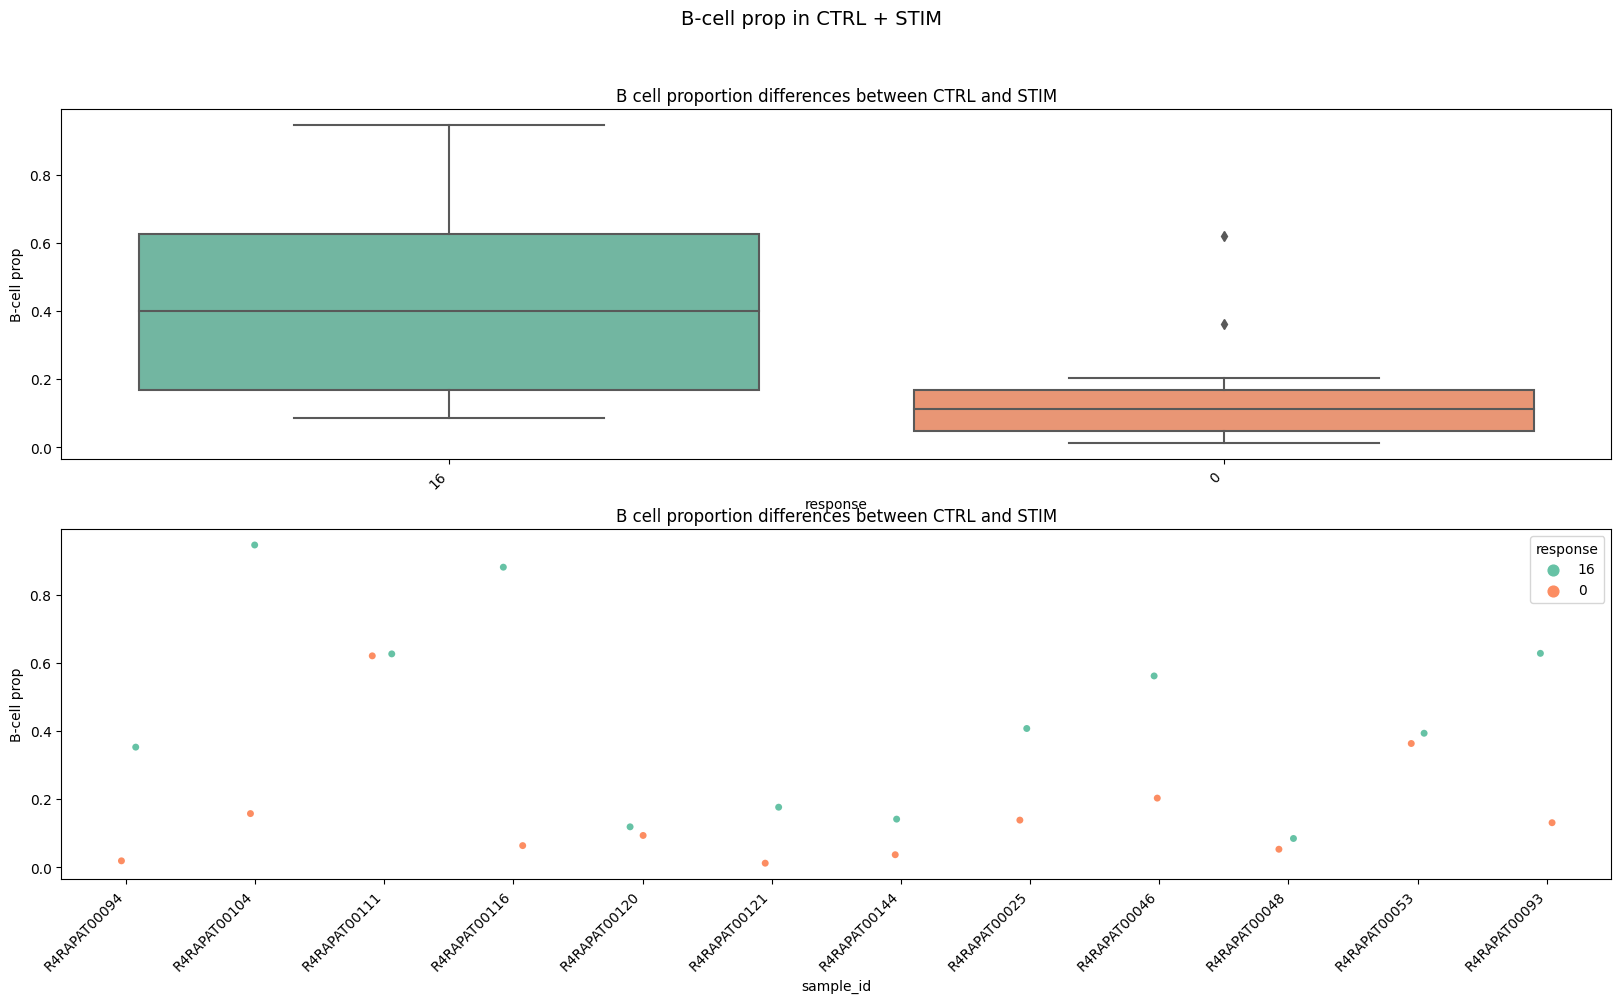

In [36]:

# plot
fig, axs = plt.subplots(2, 1, figsize=(20,10))

sns.boxplot(data=temp_meta_df, 
            x="response", y="Bplasma_cell_prop",
            ax= axs[0])
axs[0].set_title("B cell proportion differences between CTRL and STIM")
axs[0].set(ylabel="B-cell prop")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.stripplot(data=temp_meta_df, 
            x="sample_id", y="Bplasma_cell_prop",
            hue="response", ax= axs[1])
axs[1].set_title("B cell proportion differences between CTRL and STIM")
axs[1].set(ylabel="B-cell prop")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle("B-cell prop in CTRL + STIM", fontsize=14)

fig.show()



In [37]:
temp_meta_df

sample_id  stim isTraining cell_prop_type samp_type response  \
11900  R4RAPAT00094  STIM      Train      realistic      bulk       16   
11901  R4RAPAT00104  CTRL      Train      realistic      bulk        0   
11902  R4RAPAT00104  STIM      Train      realistic      bulk       16   
11903  R4RAPAT00111  CTRL      Train      realistic      bulk        0   
11904  R4RAPAT00111  STIM      Train      realistic      bulk       16   
11905  R4RAPAT00116  CTRL      Train      realistic      bulk        0   
11906  R4RAPAT00116  STIM      Train      realistic      bulk       16   
11907  R4RAPAT00120  CTRL      Train      realistic      bulk        0   
11908  R4RAPAT00120  STIM      Train      realistic      bulk       16   
11909  R4RAPAT00121  CTRL      Train      realistic      bulk        0   
11910  R4RAPAT00121  STIM      Train      realistic      bulk       16   
11911  R4RAPAT00144  CTRL      Train      realistic      bulk        0   
11912  R4RAPAT00144  STIM      Train      realistic      bulk       16   
11913  R4RAPAT00025  CTRL      Train      realistic      bulk        0   
11914  R4RAPAT00025  STIM      Train      realistic      bulk       16   
11915  R4RAPAT00046  CTRL      Train      realistic      bulk        0   
11916  R4RAPAT00046  STIM      Train      realistic      bulk       16   
11917  R4RAPAT00048  CTRL      Train      realistic      bulk        0   
11918  R4RAPAT00048  STIM      Train      realistic      bulk       16   
11919  R4RAPAT00053  CTRL      Train      realistic      bulk        0   
11920  R4RAPAT00053  STIM      Train      realistic      bulk       16   
11921  R4RAPAT00093  CTRL      Train      realistic      bulk        0   
11922  R4RAPAT00093  STIM      Train      realistic      bulk       16   
11923  R4RAPAT00094  CTRL      Train      realistic      bulk        0   

      subject_id pipeline_date site treatment  ... atac_run   qc        Y_max  \
11900        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11901        NaN           NaN  NaN       NaN  ...      NaN  NaN            T   
11902        NaN           NaN  NaN       NaN  ...      NaN  NaN   Fibroblast   
11903        NaN           NaN  NaN       NaN  ...      NaN  NaN      Myeloid   
11904        NaN           NaN  NaN       NaN  ...      NaN  NaN  B_nonplasma   
11905        NaN           NaN  NaN       NaN  ...      NaN  NaN      Myeloid   
11906        NaN           NaN  NaN       NaN  ...      NaN  NaN   Fibroblast   
11907        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11908        NaN           NaN  NaN       NaN  ...      NaN  NaN  B_nonplasma   
11909        NaN           NaN  NaN       NaN  ...      NaN  NaN  B_nonplasma   
11910        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11911        NaN           NaN  NaN       NaN  ...      NaN  NaN      Myeloid   
11912        NaN           NaN  NaN       NaN  ...      NaN  NaN  B_nonplasma   
11913        NaN           NaN  NaN       NaN  ...      NaN  NaN  B_nonplasma   
11914        NaN           NaN  NaN       NaN  ...      NaN  NaN            T   
11915        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11916        NaN           NaN  NaN       NaN  ...      NaN  NaN  Endothelial   
11917        NaN           NaN  NaN       NaN  ...      NaN  NaN   Fibroblast   
11918        NaN           NaN  NaN       NaN  ...      NaN  NaN            T   
11919        NaN           NaN  NaN       NaN  ...      NaN  NaN   Fibroblast   
11920        NaN           NaN  NaN       NaN  ...      NaN  NaN   Fibroblast   
11921        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11922        NaN           NaN  NaN       NaN  ...      NaN  NaN           NK   
11923        NaN           NaN  NaN       NaN  ...      NaN  NaN  Endothelial   

      Bplasma_cell_prop  Bnonplasma_cell_prop T_cell_prop  \
11900          0.352354              0.138400    0.041302   
11901      

In [38]:
cibersort_bulk

Mixture         B  Endothelial  Fibroblast   Myeloid  \
0   R4RAPAT00094-week16  0.021032     0.455880    0.000000  0.169629   
1    R4RAPAT00104-week0  0.584644     0.079057    0.267093  0.000000   
2   R4RAPAT00104-week16  0.000000     0.674574    0.031454  0.293972   
3    R4RAPAT00111-week0  0.000000     0.754735    0.000000  0.014058   
4   R4RAPAT00111-week16  0.000000     0.757635    0.000000  0.000000   
5    R4RAPAT00116-week0  0.000000     0.554318    0.105557  0.000000   
6   R4RAPAT00116-week16  0.000000     0.681494    0.000000  0.099214   
7    R4RAPAT00120-week0  0.303062     0.248246    0.036360  0.000000   
8   R4RAPAT00120-week16  0.678776     0.000000    0.268752  0.000000   
9    R4RAPAT00121-week0  0.351364     0.079554    0.349356  0.011218   
10  R4RAPAT00121-week16  0.276216     0.188186    0.361682  0.000000   
11   R4RAPAT00144-week0  0.507182     0.239722    0.063329  0.000000   
12  R4RAPAT00144-week16  0.274960     0.128792    0.267551  0.000000   
13   R4RAPAT00025-week0  0.635581     0.048765    0.252990  0.000000   
14  R4RAPAT00025-week16  0.240256     0.420682    0.177261  0.000000   
15   R4RAPAT00046-week0  0.797808     0.189946    0.000000  0.000000   
16  R4RAPAT00046-week16  0.000000     0.612783    0.114022  0.000000   
17   R4RAPAT00048-week0  0.564641     0.164985    0.215808  0.000000   
18  R4RAPAT00048-week16  0.589725     0.182422    0.188275  0.000000   
19   R4RAPAT00053-week0  0.000000     0.361033    0.131100  0.179617   
20  R4RAPAT00053-week16  0.000000     0.571481    0.068172  0.208337   
21   R4RAPAT00093-week0  0.483573     0.000000    0.440662  0.000000   
22  R4RAPAT00093-week16  0.000000     0.851242    0.000000  0.009335   
23   R4RAPAT00094-week0  0.489093     0.162266    0.200550  0.000000   

          NK         T  P-value  Correlation      RMSE     sample_id  
0   0.353459  0.000000        0     0.314969  0.956449  R4RAPAT00094  
1   0.069206  0.000000        0     0.359156  1.348570  R4RAPAT00104  
2   0.000000  0.000000        0     0.246008  0.976973  R4RAPAT00104  
3   0.231207  0.000000        0     0.171429  1.012294  R4RAPAT00111  
4   0.242365  0.000000        0     0.155926  1.019276  R4RAPAT00111  
5   0.340126  0.000000        0     0.248885  0.983046  R4RAPAT00116  
6   0.219292  0.000000        0     0.217504  0.991521  R4RAPAT00116  
7   0.412332  0.000000        0     0.395720  1.056306  R4RAPAT00120  
8   0.052472  0.000000        0     0.466941  1.352160  R4RAPAT00120  
9   0.133836  0.074671        0     0.347802  1.138544  R4RAPAT00121  
10  0.167349  0.006567        0     0.438999  0.983570  R4RAPAT00121  
11  0.189766  0.000000        0     0.361414  1.265463  R4RAPAT00144  
12  0.036691  0.292006        0     0.324617  1.145027  R4RAPAT00144  
13  0.008570  0.054093        0     0.421987  1.359872  R4RAPAT00025  
14  0.161800  0.000000        0     0.452038  0.946248  R4RAPAT00025  
15  0.012246  0.000000        0     0.301484  1.670801  R4RAPAT00046  
16  0.273196  0.000000        0     0.221432  0.992892  R4RAPAT00046  
17  0.015870  0.038697        0     0.410978  1.277874  R4RAPAT00048  
18  0.000000  0.039577        0     0.574129  1.124848  R4RAPAT00048  
19  0.328251  0.000000        0     0.142715  1.022831  R4RAPAT00053  
20  0.152011  0.000000        0     0.259620  0.972767  R4RAPAT00053  
21  0.000000  0.075765        0     0.539024  1.069274  R4RAPAT00093  
22  0.139423  0.000000        0     0.195262  1.001292  R4RAPAT00093  
23  0.148091  0.000000        0     0.336140  1.266613  R4RAPAT00094

In [39]:
cibersort_bulk = pd.read_csv("/Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/results/bulk/CIBERSORTx_Job28_Results.csv")

# format sample name
cibersort_bulk['sample_id'] = cibersort_bulk['Mixture'].str[:12]

cibersort_bulk[['sample_id','time']] = cibersort_bulk['Mixture'].str.split('-',expand=True)
#cibersort_bulk['sample_id'] = cibersort_bulk['Mixture']

def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "week0":
        out_str = "CTRL"
           
    return(out_str)

cibersort_bulk['stim'] = [get_stim_id(str(x)) for x in cibersort_bulk["time"].tolist()]


temp_meta_df = temp_meta_df.merge(cibersort_bulk, on=["sample_id", "stim"])
temp_meta_df

sample_id  stim isTraining cell_prop_type samp_type response  \
0   R4RAPAT00094  STIM      Train      realistic      bulk       16   
1   R4RAPAT00104  CTRL      Train      realistic      bulk        0   
2   R4RAPAT00104  STIM      Train      realistic      bulk       16   
3   R4RAPAT00111  CTRL      Train      realistic      bulk        0   
4   R4RAPAT00111  STIM      Train      realistic      bulk       16   
5   R4RAPAT00116  CTRL      Train      realistic      bulk        0   
6   R4RAPAT00116  STIM      Train      realistic      bulk       16   
7   R4RAPAT00120  CTRL      Train      realistic      bulk        0   
8   R4RAPAT00120  STIM      Train      realistic      bulk       16   
9   R4RAPAT00121  CTRL      Train      realistic      bulk        0   
10  R4RAPAT00121  STIM      Train      realistic      bulk       16   
11  R4RAPAT00144  CTRL      Train      realistic      bulk        0   
12  R4RAPAT00144  STIM      Train      realistic      bulk       16   
13  R4RAPAT00025  CTRL      Train      realistic      bulk        0   
14  R4RAPAT00025  STIM      Train      realistic      bulk       16   
15  R4RAPAT00046  CTRL      Train      realistic      bulk        0   
16  R4RAPAT00046  STIM      Train      realistic      bulk       16   
17  R4RAPAT00048  CTRL      Train      realistic      bulk        0   
18  R4RAPAT00048  STIM      Train      realistic      bulk       16   
19  R4RAPAT00053  CTRL      Train      realistic      bulk        0   
20  R4RAPAT00053  STIM      Train      realistic      bulk       16   
21  R4RAPAT00093  CTRL      Train      realistic      bulk        0   
22  R4RAPAT00093  STIM      Train      realistic      bulk       16   
23  R4RAPAT00094  CTRL      Train      realistic      bulk        0   

   subject_id pipeline_date site treatment  ...         B Endothelial  \
0         NaN           NaN  NaN       NaN  ...  0.021032    0.455880   
1         NaN           NaN  NaN       NaN  ...  0.584644    0.079057   
2         NaN           NaN  NaN       NaN  ...  0.000000    0.674574   
3         NaN           NaN  NaN       NaN  ...  0.000000    0.754735   
4         NaN           NaN  NaN       NaN  ...  0.000000    0.757635   
5         NaN           NaN  NaN       NaN  ...  0.000000    0.554318   
6         NaN           NaN  NaN       NaN  ...  0.000000    0.681494   
7         NaN           NaN  NaN       NaN  ...  0.303062    0.248246   
8         NaN           NaN  NaN       NaN  ...  0.678776    0.000000   
9         NaN           NaN  NaN       NaN  ...  0.351364    0.079554   
10        NaN           NaN  NaN       NaN  ...  0.276216    0.188186   
11        NaN           NaN  NaN       NaN  ...  0.507182    0.239722   
12        NaN           NaN  NaN       NaN  ...  0.274960    0.128792   
13        NaN           NaN  NaN       NaN  ...  0.635581    0.048765   
14        NaN           NaN  NaN       NaN  ...  0.240256    0.420682   
15        NaN           NaN  NaN       NaN  ...  0.797808    0.189946   
16        NaN           NaN  NaN       NaN  ...  0.000000    0.612783   
17        NaN           NaN  NaN       NaN  ...  0.564641    0.164985   
18        NaN           NaN  NaN       NaN  ...  0.589725    0.182422   
19        NaN           NaN  NaN       NaN  ...  0.000000    0.361033   
20        NaN           NaN  NaN       NaN  ...  0.000000    0.571481   
21        NaN           NaN  NaN       NaN  ...  0.483573    0.000000   
22        NaN           NaN  NaN       NaN  ...  0.000000    0.851242   
23        NaN           NaN  NaN       NaN  ...  0.489093    0.162266   

    Fibroblast   Myeloid        NK         T  P-value  Correlation      RMSE  \
0     0.000000  0.169629  0.353459  0.000000        0     0.314969  0.956449   
1     0.267093  0.000000  0.069206  0.000000        0     0.359156  1.348570   
2     0.031454  0.293972  0.000000  0.000000        0     0.246008  0.976973   
3     0.000000  0.014058  0.231207  0.000000        0     0.171429  1.012294   
4    

In [41]:
temp_meta_df.loc[:,["sample_id", "stim", "Bplasma_cell_prop", "B", "Bnonplasma_cell_prop", "B", "T_cell_prop", "T", "Endothelial_cell_prop", "Endothelial", "Fibroblast_cell_prop", "Fibroblast", "Myeloid_cell_prop", "Myeloid", "NK_cell_prop", "NK"]]

sample_id  stim  Bplasma_cell_prop         B  Bnonplasma_cell_prop  \
0   R4RAPAT00094  STIM           0.352354  0.021032              0.138400   
1   R4RAPAT00104  CTRL           0.157200  0.584644              0.089219   
2   R4RAPAT00104  STIM           0.945912  0.000000              0.026867   
3   R4RAPAT00111  CTRL           0.620385  0.000000              0.092376   
4   R4RAPAT00111  STIM           0.626132  0.000000              0.177307   
5   R4RAPAT00116  CTRL           0.063164  0.000000              0.105122   
6   R4RAPAT00116  STIM           0.880756  0.000000              0.040386   
7   R4RAPAT00120  CTRL           0.092997  0.303062              0.230196   
8   R4RAPAT00120  STIM           0.118303  0.678776              0.042270   
9   R4RAPAT00121  CTRL           0.011587  0.351364              0.092398   
10  R4RAPAT00121  STIM           0.175985  0.276216              0.156565   
11  R4RAPAT00144  CTRL           0.036396  0.507182              0.731307   
12  R4RAPAT00144  STIM           0.140938  0.274960              0.212809   
13  R4RAPAT00025  CTRL           0.138031  0.635581              0.043328   
14  R4RAPAT00025  STIM           0.407067  0.240256              0.019541   
15  R4RAPAT00046  CTRL           0.202673  0.797808              0.133716   
16  R4RAPAT00046  STIM           0.561373  0.000000              0.130897   
17  R4RAPAT00048  CTRL           0.052521  0.564641              0.067059   
18  R4RAPAT00048  STIM           0.084107  0.589725              0.065472   
19  R4RAPAT00053  CTRL           0.363000  0.000000              0.027636   
20  R4RAPAT00053  STIM           0.393125  0.000000              0.138427   
21  R4RAPAT00093  CTRL           0.130408  0.483573              0.169474   
22  R4RAPAT00093  STIM           0.627720  0.000000              0.111550   
23  R4RAPAT00094  CTRL           0.018458  0.489093              0.510482   

           B  T_cell_prop         T  Endothelial_cell_prop  Endothelial  \
0   0.021032     0.041302  0.000000               0.039426     0.455880   
1   0.584644     0.075120  0.000000               0.011109     0.079057   
2   0.000000     0.000476  0.000000               0.006398     0.674574   
3   0.000000     0.008245  0.000000               0.032915     0.754735   
4   0.000000     0.004533  0.000000               0.019824     0.757635   
5   0.000000     0.010637  0.000000               0.048638     0.554318   
6   0.000000     0.004186  0.000000               0.008711     0.681494   
7   0.303062     0.343918  0.000000               0.066891     0.248246   
8   0.678776     0.325270  0.000000               0.052515     0.000000   
9   0.351364     0.738799  0.074671               0.017921     0.079554   
10  0.276216     0.135246  0.006567               0.030203     0.188186   
11  0.507182     0.046023  0.000000               0.007283     0.239722   
12  0.274960     0.124553  0.292006               0.006484     0.128792   
13  0.635581     0.191656  0.054093               0.089176     0.048765   
14  0.240256     0.079163  0.000000               0.053145     0.420682   
15  0.797808     0.327328  0.000000               0.050459     0.189946   
16  0.000000     0.010227  0.000000               0.025105     0.612783   
17  0.564641     0.095456  0.038697               0.079901     0.164985   
18  0.589725     0.035406  0.039577               0.039628     0.182422   
19  0.000000     0.020549  0.000000               0.081393     0.361033   
20  0.000000     0.021482  0.000000               0.087751     0.571481   
21  0.483573     0.123420  0.075765               0.049526     0.000000   
22  0.000000     0.017003  0.000000               0.067581     0.851242   
23  0.489093     0.029687  0.000000               0.001619     0.162266   

    Fibroblast_cell_prop  Fibroblast  Myeloid_cell_prop   Myeloid  \
0               0.141889    0.000000           0.013547  0.169629   
1               0.119661    0.267093           0.008462  0.000000  

In [58]:
np.corrcoef(temp_meta_df.Bplasma_cell_prop, temp_meta_df.B)

array([[ 1.        , -0.69841132],
       [-0.69841132,  1.        ]])

In [45]:
np.corrcoef(temp_meta_df.Bnonplasma_cell_prop, temp_meta_df.B)

array([[1.        , 0.19673056],
       [0.19673056, 1.        ]])

In [46]:
np.corrcoef(temp_meta_df.T_cell_prop, temp_meta_df["T"])

array([[1.       , 0.2030761],
       [0.2030761, 1.       ]])

In [47]:
np.corrcoef(temp_meta_df.Fibroblast_cell_prop, temp_meta_df.Fibroblast)

array([[1.        , 0.53520696],
       [0.53520696, 1.        ]])

In [48]:
np.corrcoef(temp_meta_df.Myeloid_cell_prop, temp_meta_df.Myeloid)

array([[1.        , 0.41910942],
       [0.41910942, 1.        ]])

In [49]:
np.corrcoef(temp_meta_df.NK_cell_prop, temp_meta_df.NK)

array([[ 1.        , -0.10798805],
       [-0.10798805,  1.        ]])

In [50]:
np.corrcoef(temp_meta_df.Endothelial_cell_prop, temp_meta_df.Endothelial)

array([[ 1.        , -0.05444595],
       [-0.05444595,  1.        ]])

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/2115050272.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


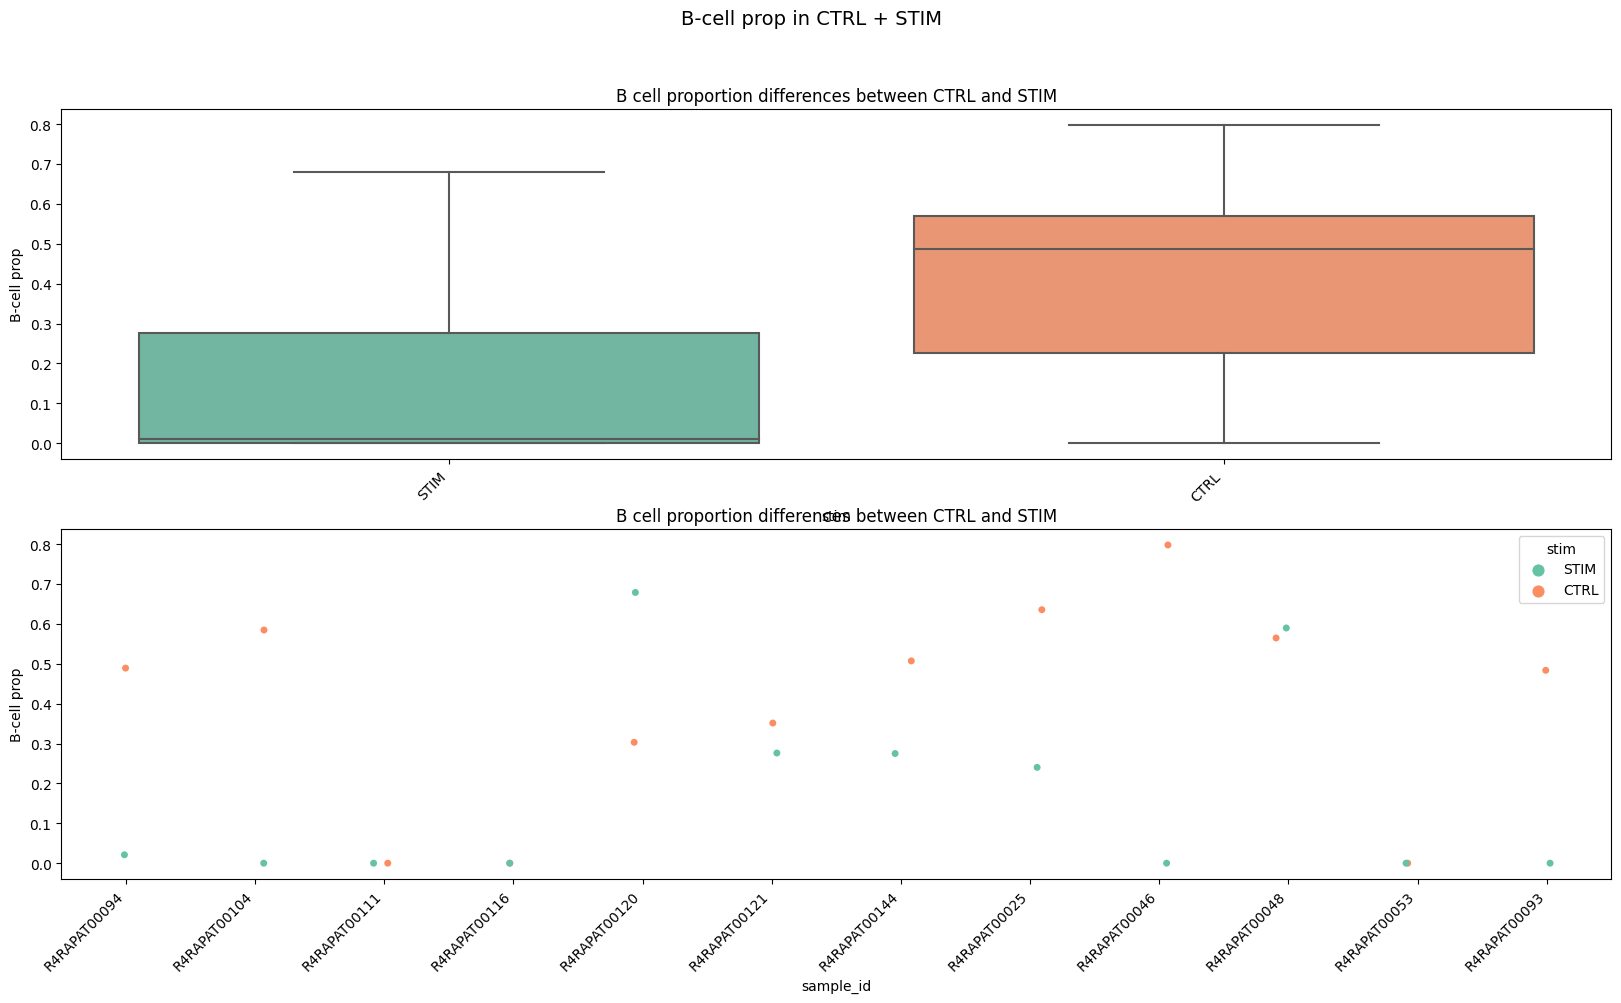

In [51]:

# plot
fig, axs = plt.subplots(2, 1, figsize=(20,10))

sns.boxplot(data=temp_meta_df, 
            x="stim", y="B",
            ax= axs[0])
axs[0].set_title("B cell proportion differences between CTRL and STIM")
axs[0].set(ylabel="B-cell prop")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.stripplot(data=temp_meta_df, 
            x="sample_id", y="B",
            hue="stim", ax= axs[1])
axs[1].set_title("B cell proportion differences between CTRL and STIM")
axs[1].set(ylabel="B-cell prop")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle("B-cell prop in CTRL + STIM", fontsize=14)

fig.show()



/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/3994685008.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


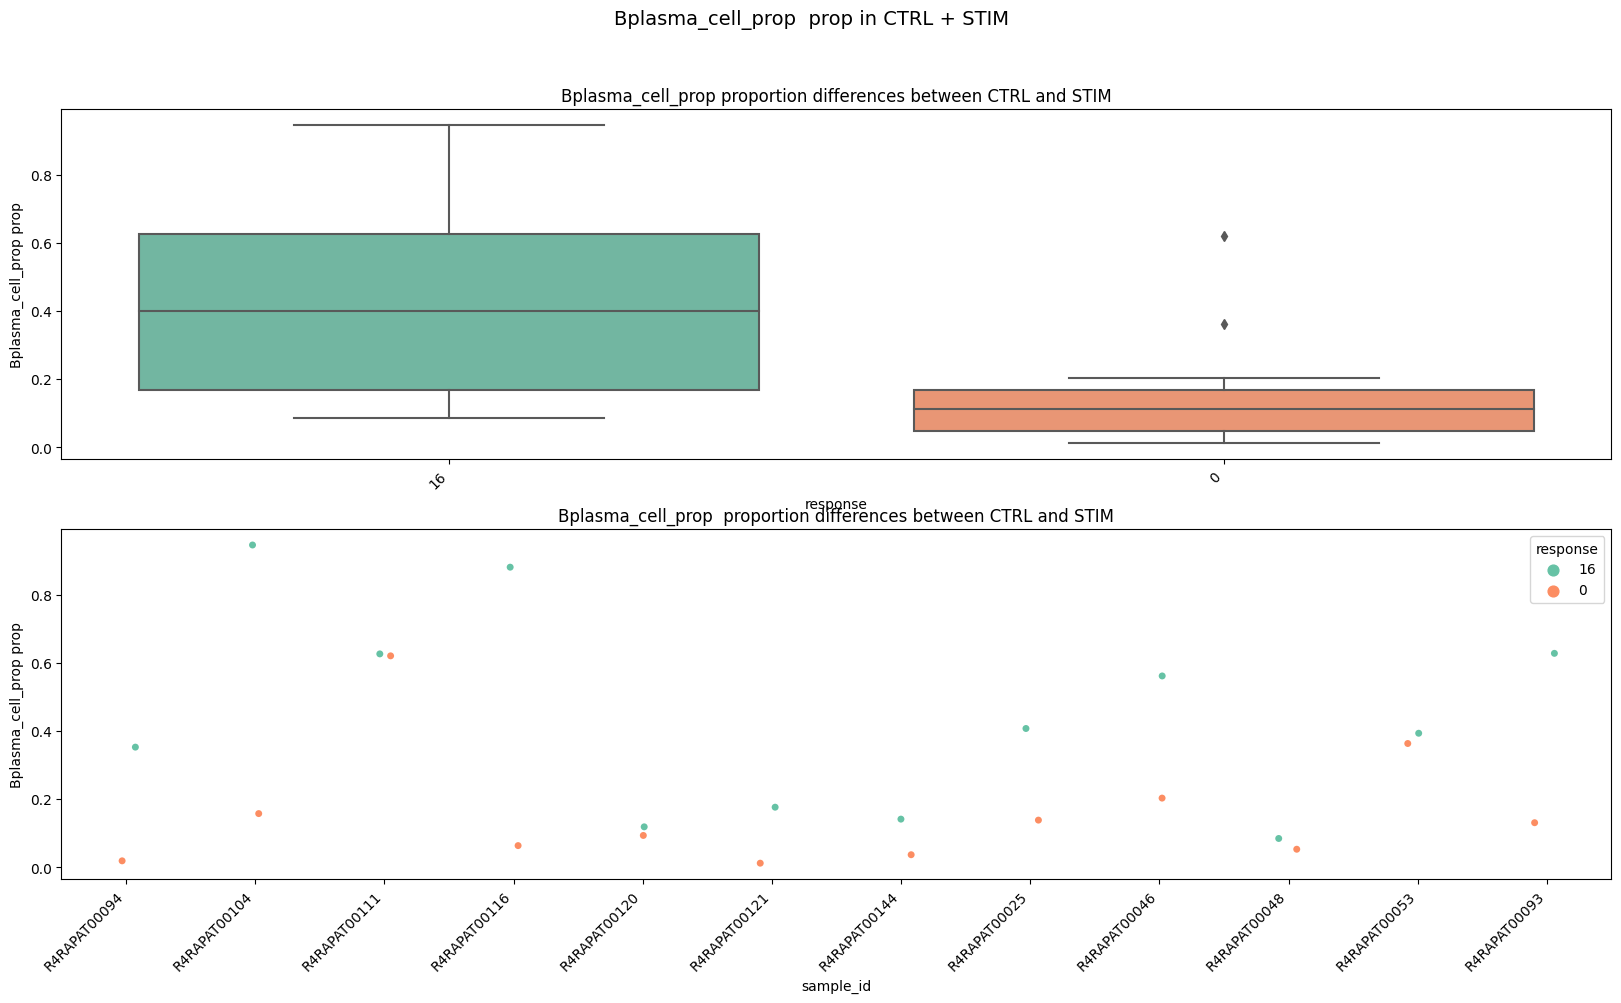

In [52]:
# plot
cur_val = "Bplasma_cell_prop"
x_val = "response"

fig, axs = plt.subplots(2, 1, figsize=(20,10))

sns.boxplot(data=temp_meta_df, 
            x=x_val, y=cur_val,
            ax= axs[0])
axs[0].set_title(f"{cur_val} proportion differences between CTRL and STIM")
axs[0].set(ylabel=f"{cur_val} prop")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.stripplot(data=temp_meta_df, 
            x="sample_id", y=cur_val,
            hue=x_val, ax= axs[1])
axs[1].set_title(f"{cur_val}  proportion differences between CTRL and STIM")
axs[1].set(ylabel=f"{cur_val} prop")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle(f"{cur_val}  prop in CTRL + STIM", fontsize=14)

fig.show()

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/3162834822.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


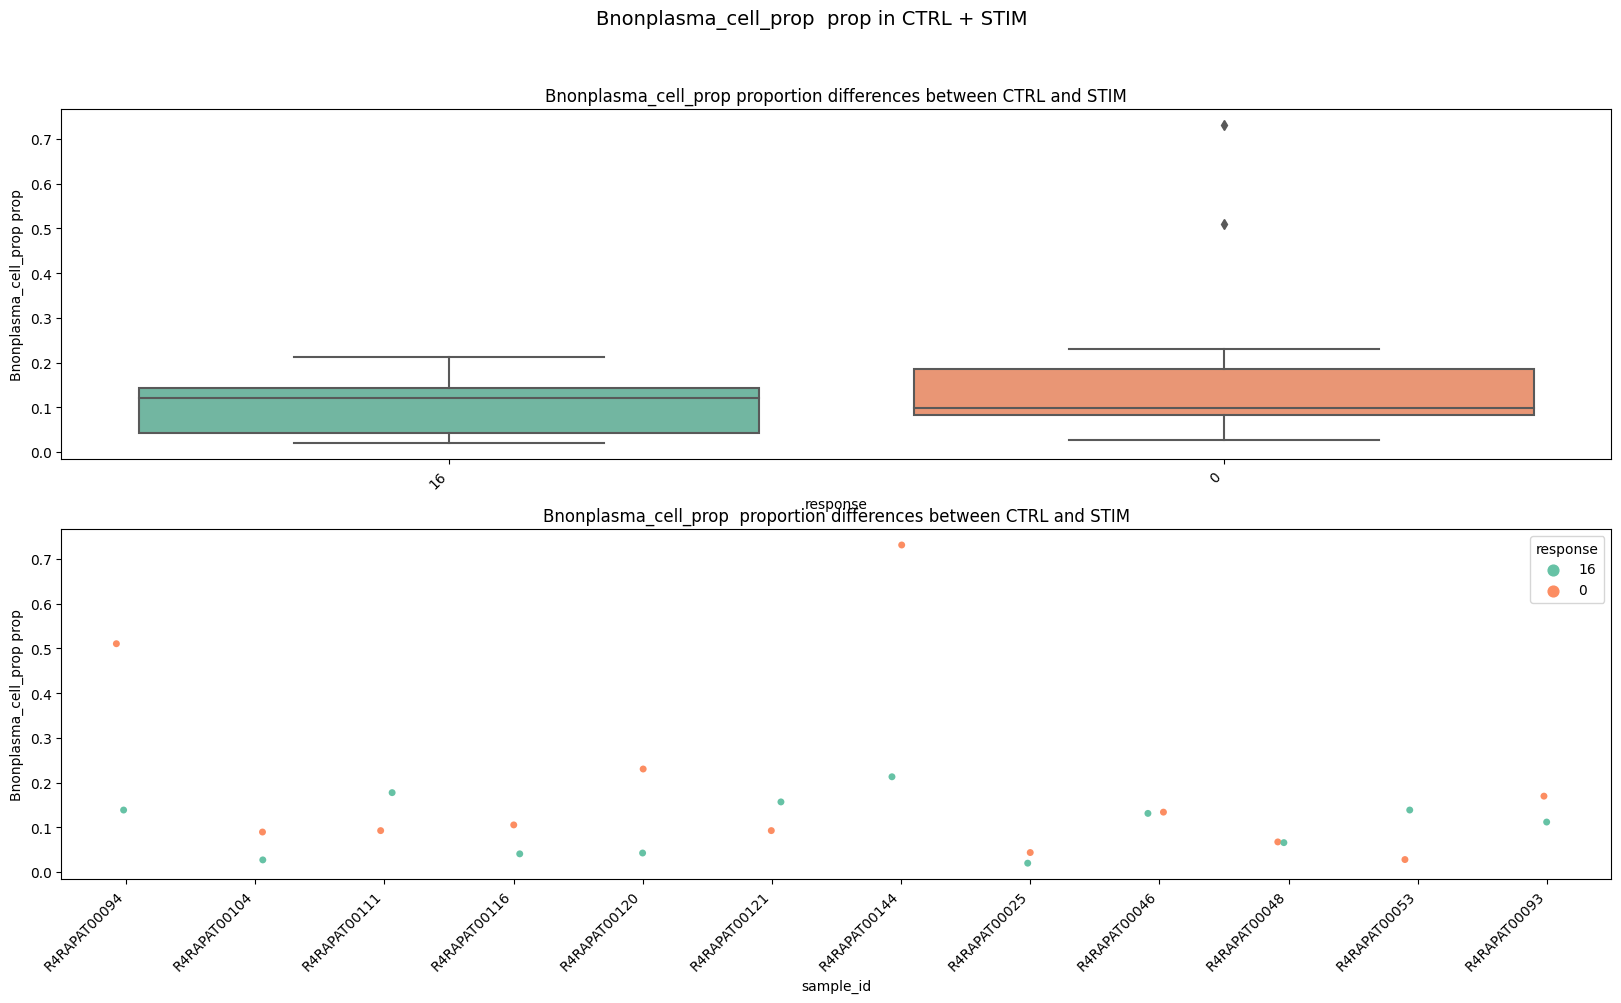

In [53]:
# plot
cur_val = "Bnonplasma_cell_prop"
x_val = "response"

fig, axs = plt.subplots(2, 1, figsize=(20,10))

sns.boxplot(data=temp_meta_df, 
            x=x_val, y=cur_val,
            ax= axs[0])
axs[0].set_title(f"{cur_val} proportion differences between CTRL and STIM")
axs[0].set(ylabel=f"{cur_val} prop")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.stripplot(data=temp_meta_df, 
            x="sample_id", y=cur_val,
            hue=x_val, ax= axs[1])
axs[1].set_title(f"{cur_val}  proportion differences between CTRL and STIM")
axs[1].set(ylabel=f"{cur_val} prop")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle(f"{cur_val}  prop in CTRL + STIM", fontsize=14)

fig.show()

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/4158439759.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


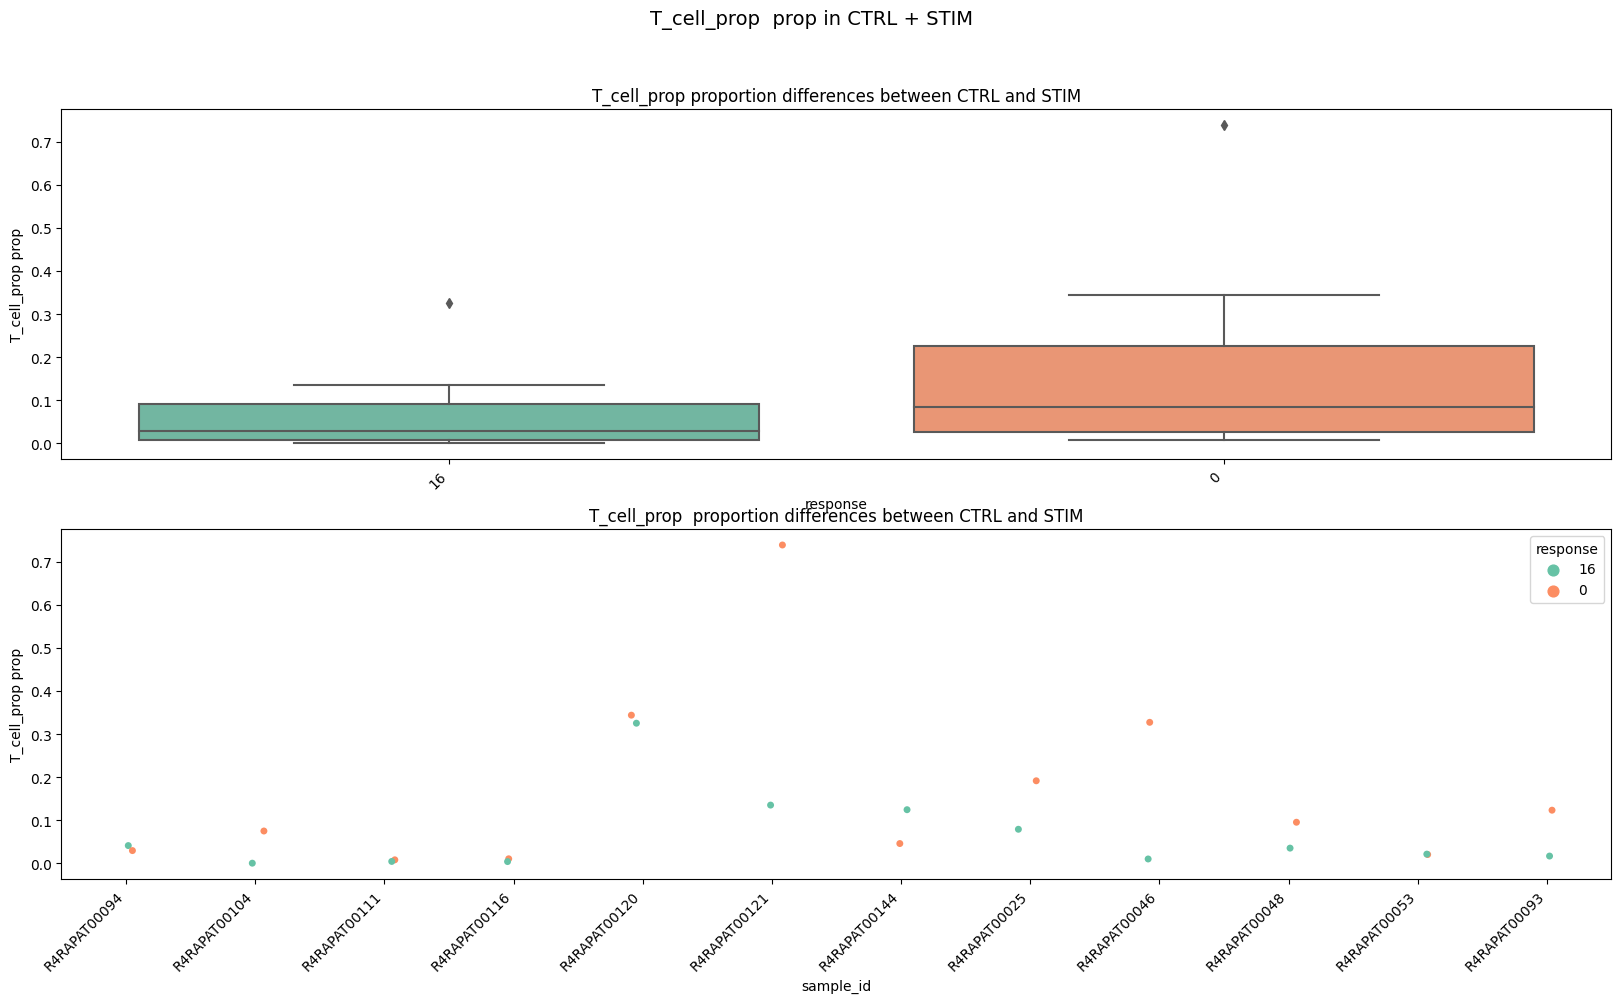

In [54]:
# plot
cur_val = "T_cell_prop"
x_val = "response"

fig, axs = plt.subplots(2, 1, figsize=(20,10))

sns.boxplot(data=temp_meta_df, 
            x=x_val, y=cur_val,
            ax= axs[0])
axs[0].set_title(f"{cur_val} proportion differences between CTRL and STIM")
axs[0].set(ylabel=f"{cur_val} prop")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.stripplot(data=temp_meta_df, 
            x="sample_id", y=cur_val,
            hue=x_val, ax= axs[1])
axs[1].set_title(f"{cur_val}  proportion differences between CTRL and STIM")
axs[1].set(ylabel=f"{cur_val} prop")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle(f"{cur_val}  prop in CTRL + STIM", fontsize=14)

fig.show()

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/1792549632.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


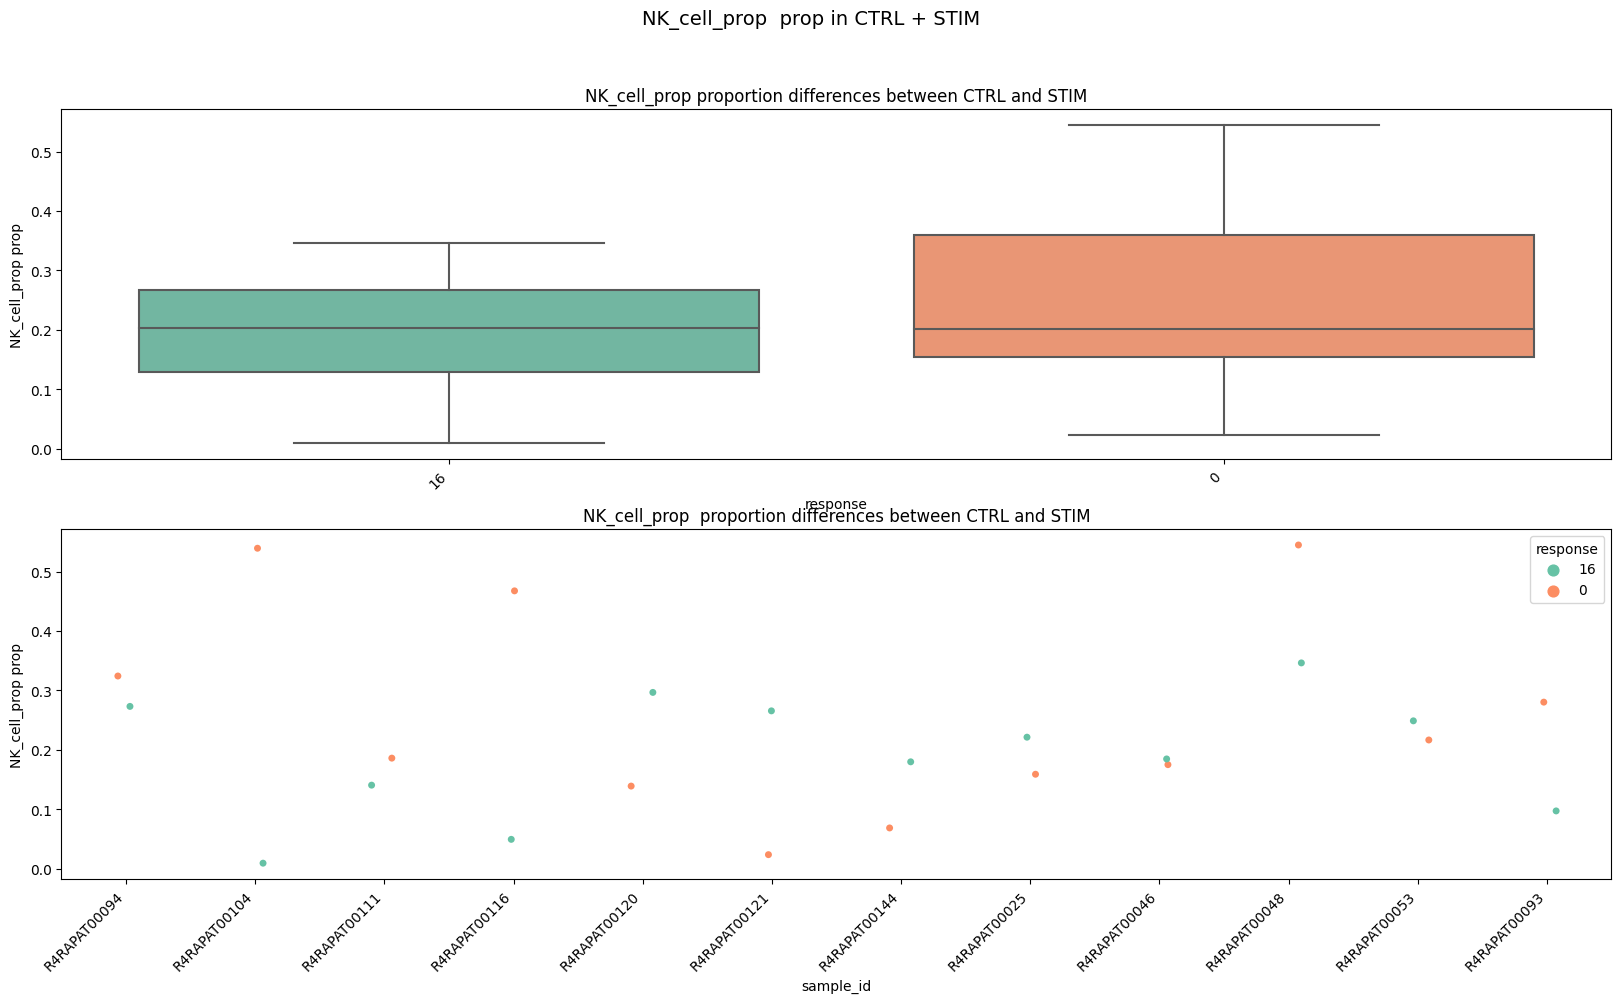

In [55]:
# plot
cur_val = "NK_cell_prop"
x_val = "response"

fig, axs = plt.subplots(2, 1, figsize=(20,10))

sns.boxplot(data=temp_meta_df, 
            x=x_val, y=cur_val,
            ax= axs[0])
axs[0].set_title(f"{cur_val} proportion differences between CTRL and STIM")
axs[0].set(ylabel=f"{cur_val} prop")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.stripplot(data=temp_meta_df, 
            x="sample_id", y=cur_val,
            hue=x_val, ax= axs[1])
axs[1].set_title(f"{cur_val}  proportion differences between CTRL and STIM")
axs[1].set(ylabel=f"{cur_val} prop")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle(f"{cur_val}  prop in CTRL + STIM", fontsize=14)

fig.show()

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/4190515523.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


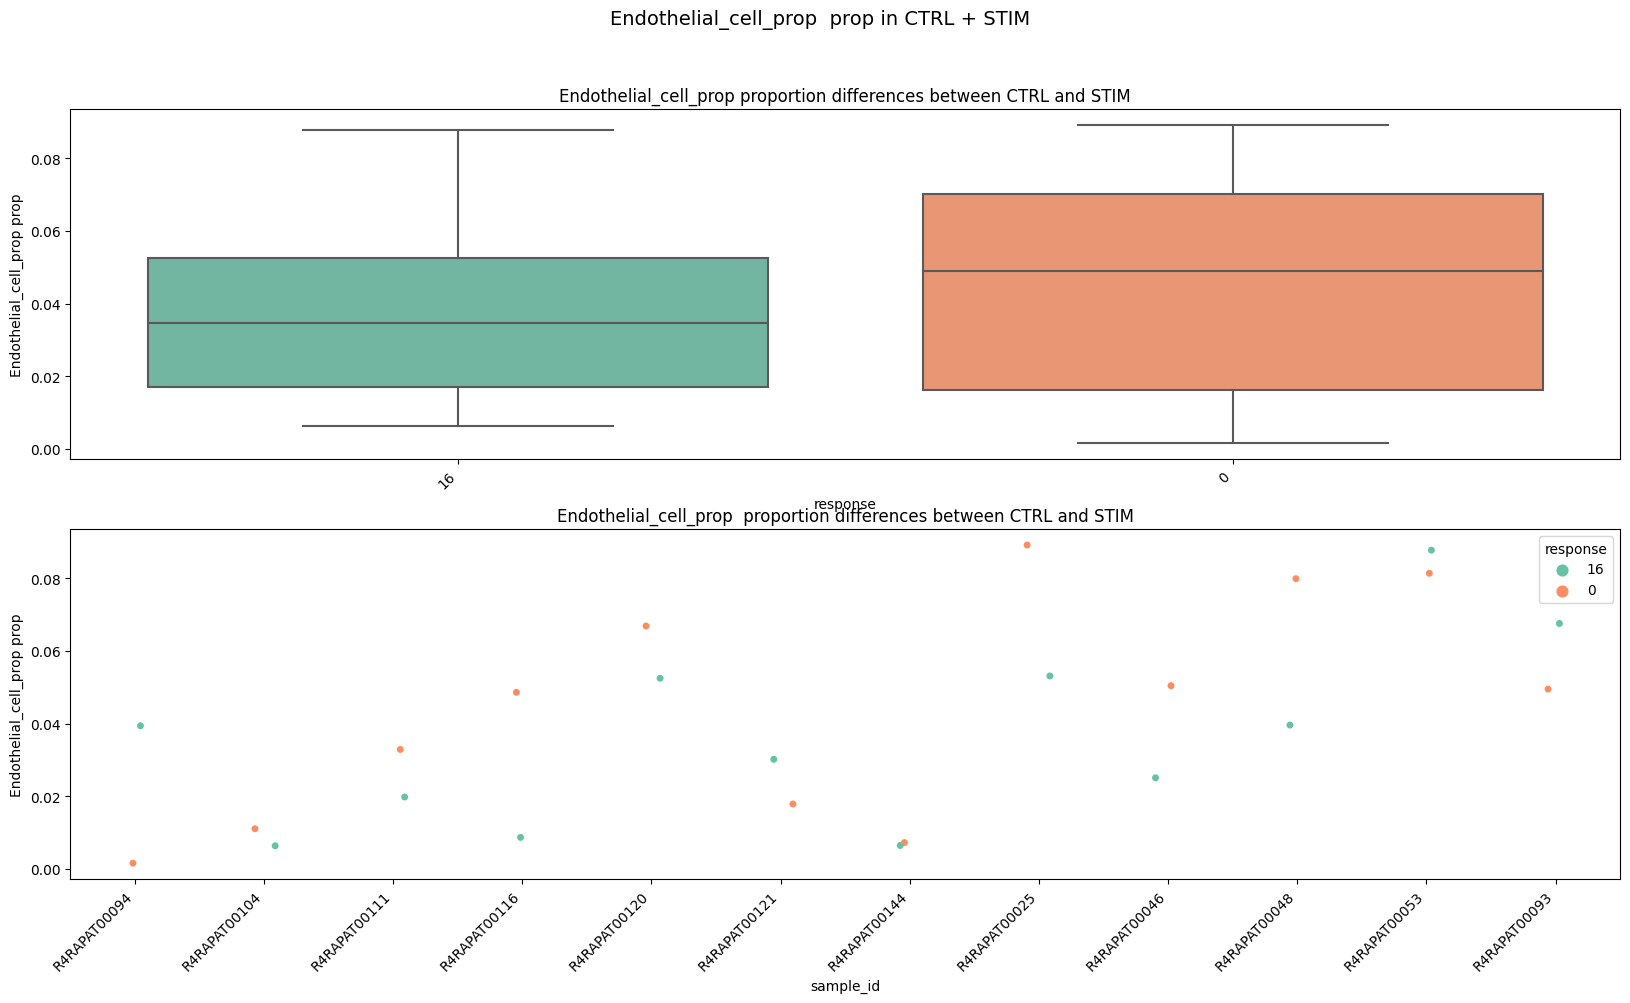

In [56]:
# plot
cur_val = "Endothelial_cell_prop"
x_val = "response"

fig, axs = plt.subplots(2, 1, figsize=(20,10))

sns.boxplot(data=temp_meta_df, 
            x=x_val, y=cur_val,
            ax= axs[0])
axs[0].set_title(f"{cur_val} proportion differences between CTRL and STIM")
axs[0].set(ylabel=f"{cur_val} prop")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.stripplot(data=temp_meta_df, 
            x="sample_id", y=cur_val,
            hue=x_val, ax= axs[1])
axs[1].set_title(f"{cur_val}  proportion differences between CTRL and STIM")
axs[1].set(ylabel=f"{cur_val} prop")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle(f"{cur_val}  prop in CTRL + STIM", fontsize=14)

fig.show()

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_30957/2006113092.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


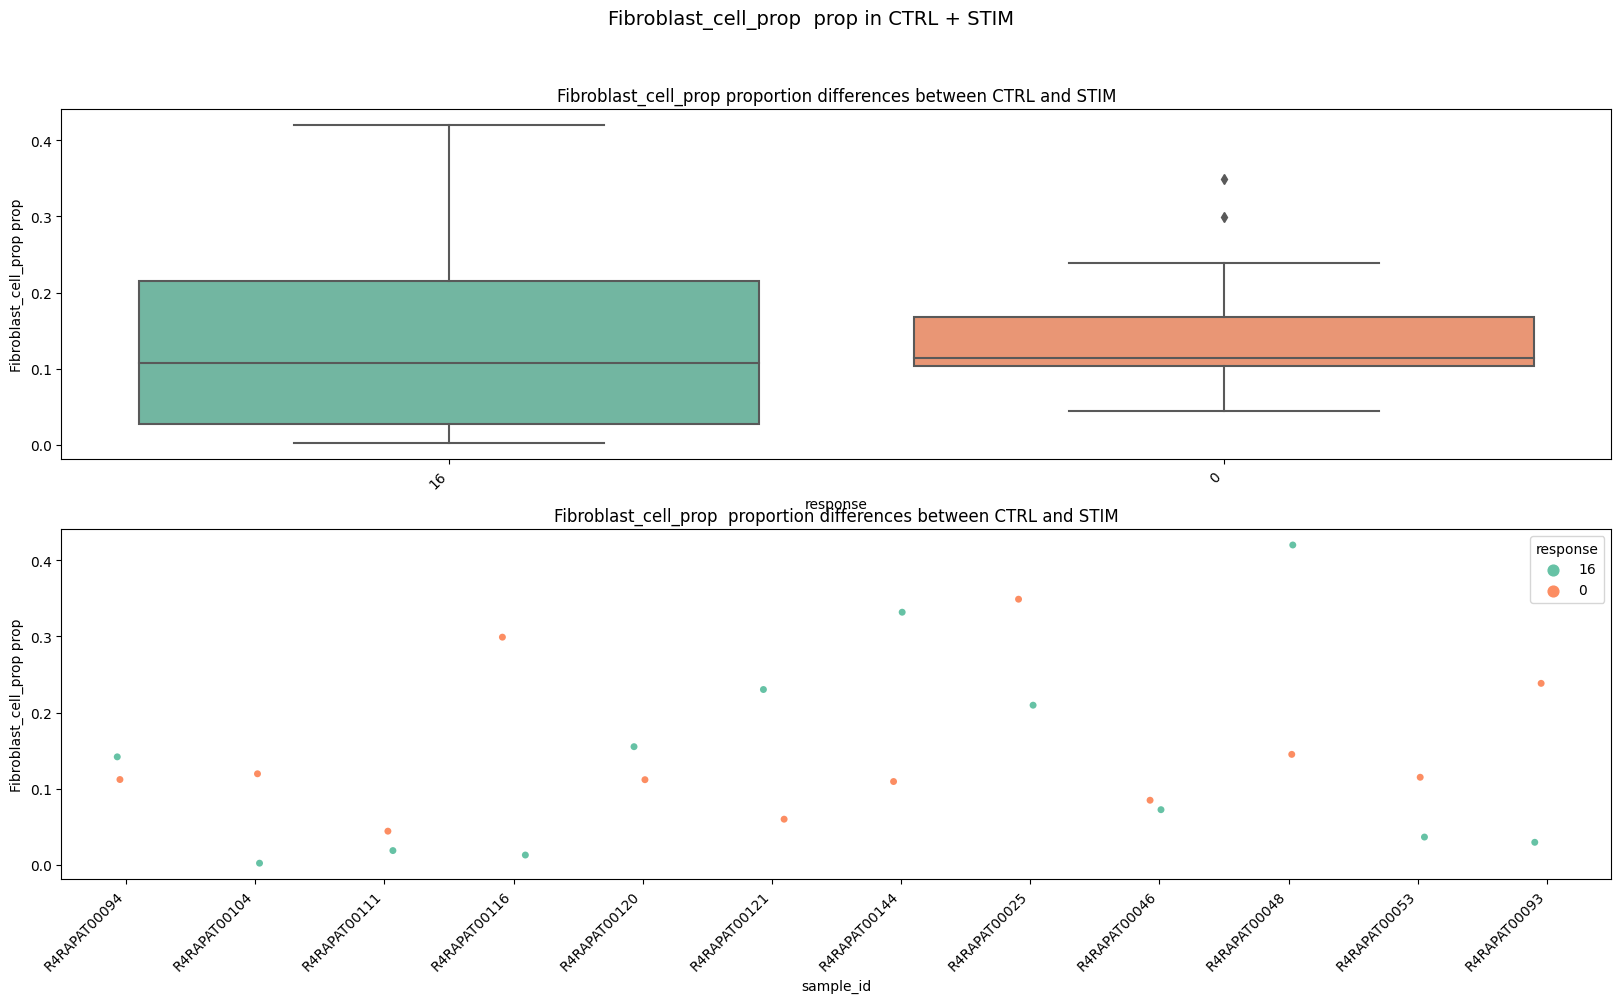

In [57]:
# plot
cur_val = "Fibroblast_cell_prop"
x_val = "response"

fig, axs = plt.subplots(2, 1, figsize=(20,10))

sns.boxplot(data=temp_meta_df, 
            x=x_val, y=cur_val,
            ax= axs[0])
axs[0].set_title(f"{cur_val} proportion differences between CTRL and STIM")
axs[0].set(ylabel=f"{cur_val} prop")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')


sns.stripplot(data=temp_meta_df, 
            x="sample_id", y=cur_val,
            hue=x_val, ax= axs[1])
axs[1].set_title(f"{cur_val}  proportion differences between CTRL and STIM")
axs[1].set(ylabel=f"{cur_val} prop")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')


fig.suptitle(f"{cur_val}  prop in CTRL + STIM", fontsize=14)

fig.show()